In [138]:
import matplotlib.pyplot as plt
import numpy as np
import pprint

from qutip import *
import os

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({
#    'text.usetex': True,              # Enable LaTeX for text rendering
#    'font.family': 'serif',           # Use a serif font family
#    'font.serif': 'Palatino',         # Set Palatino as the serif font
#    'text.latex.preamble': r'\usepackage{amsmath}',
#    'font.size': 20,                   # Font size for general text
#    'axes.titlesize': 20,              # Font size for axis titles
#    'axes.labelsize': 20,              # Font size for axis labels
#    'xtick.labelsize': 20,             # Font size for x-axis tick labels
#    'ytick.labelsize': 20,             # Font size for y-axis tick labels
#    'legend.fontsize': 20,             # Font size for legends
#    'figure.figsize': [8, 6],          # Size of the plot (width x height)
#    'figure.autolayout': True,         # Automatic layout adjustment
#    'savefig.format': 'svg',           # Default format for saving figures
#    'figure.facecolor': 'none',        # Make the figure face color transparent
#    'axes.facecolor': 'none',          # Make the axes face color transparent
#    'savefig.transparent': True        # Save figures with transparent background
})
output_dir = r"C:\Users\leopo\OneDrive - UT Cloud\Uni\Semester_9\Master_thesis\Figures_From_Python"
os.makedirs(output_dir, exist_ok=True)

# allows for interactive plots
#%matplotlib notebook

$$
H = H_0 + H_I
$$
$$
H_0 = \hbar  \omega_a \sum_{i=1}^{N_{\text{atoms}}} \sigma_+^{(i)} \sigma_-^{(i)}
+ \hbar \sum_{i,j=1}^{N_\text{{atoms}}} J_{i j} \sigma_+^{(i)} \sigma_-^{(j)}
+ \hbar \omega_c a^{\dagger}a
$$

$$
H_I = \hbar  g \Sigma_x (a^{\dagger} + a).
$$

$$
\displaystyle J_{i j} = \frac{\alpha}{|r_i-r_j|}.
$$

In [368]:

#
# Set the system parameters
#
# ENERGY LANDSCAPE, c = 1, hbar = 1
fixed_lam = 1.
alpha     = 1.                      # coupling strength of the dipoles
omega_a   = 2 * np.pi / fixed_lam   # energysplitting of the atom, when ground state is set to 0
omega_c   = 1 * omega_a             # energysplitting of the field  Rabi freq coupling to laser field  for first 2 lasers  -> E_field_0 dot dot Dip_op, parallel
Omega_coupling     = .1 * omega_a # energysplitting of the field  Rabi freq coupling to laser field  for first 2 lasers  -> E_field_0 dot dot Dip_op, parallel
mu        = 1 * omega_a             # Dipole matrix element of each atom

# LINBLAD OPS
gamma_0   = .1 # decay rate of the atoms
gamma_kappa = .1 # decay rate of the cavity
gamma_phi = .1 # dephasing rate of the atoms
# TOPOLOGY
n_chains = 3 # number of chains
n_rings  = 1 # number of rings
N_atoms  = n_chains * n_rings  # number of atoms

distance = 1. # * fixed_lam # defining topology

# TIME EVOLUTION
last_pulse = 10 # * gamma_0
last_det_t = 1 * last_pulse # last time when the system is measured -> t elem 0...last_det_t - T
time_steps = 100
times = np.linspace(0, last_det_t, time_steps) # list of times

In [369]:
########################################               define the geometry                 #############################################
def chain_positions(distance, N_atoms):
    Pos = np.zeros((N_atoms, 3))
    for i in range(N_atoms):
        Pos[i, 2] = i * distance
    return Pos
def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0,              0,            1]])
def ring_positions(distance, n_chains):
    Pos = np.zeros((n_chains, 3))
    dphi = 2 * np.pi / n_chains
    if n_chains == 1:
        radius = 0
    else:
        radius = distance / 2 / np.sin(np.pi / n_chains)
    helper = np.array([radius, 0, 0])
    for i in range(n_chains):
        rotation_matrix = z_rotation(dphi * i)
        Pos[i] = np.matmul(rotation_matrix, helper)
    return Pos
def cyl_positions(distance, N_atoms, n_chains):
    Pos = np.zeros((N_atoms, 3))
    Pos_chain = chain_positions(distance, N_atoms // n_chains)
    Pos_ring = ring_positions(distance, n_chains)
    for i in range(n_chains):
        Pos[i * (N_atoms // n_chains): (i + 1) * (N_atoms // n_chains)] = Pos_chain + Pos_ring[i]
    return Pos
################## help functions
def count_decimal_digits(number):
    # Convert the number to string
    str_number = str(number)

    # Split the string at the decimal point and count the digits after it
    if '.' in str_number:
        return len(str_number.split('.')[1])
    else:
        return 0  # No digits after decimal if it's an integer
tolerance = count_decimal_digits(times[1]) - 2
def truncate_number(number, decimals=0):
    factor = 10.0 ** decimals
    return int(number * factor) / factor
def heaviside(x):
    return 1 if x >= 0 else 0
options = Options(store_states=True)

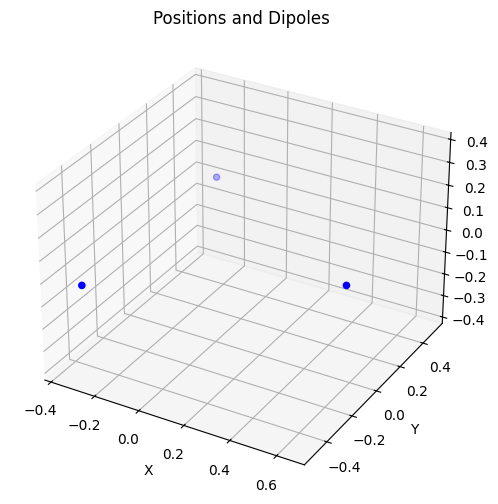

In [370]:
# vizualizing the atomic positions
Pos = cyl_positions(distance, N_atoms, n_chains)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Pos[:, 0], Pos[:, 1], Pos[:, 2], c='b', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Positions and Dipoles')
ax.axis('equal')
plt.show()

In [371]:
# Define the ground & the excited states
# atomic dofs
atom_g = basis(N_atoms+1, 0)
atom_es = [basis(N_atoms + 1, i) for i in range(1, N_atoms + 1)]

# cavity dofs
cav_g = basis(2, 0)
cav_e = basis(2, 1)

# combined dofs
sm_list = []    # lowering operators of atomic system
Dip_op = 0      # collective sigma_x operator for the system
Sigma_m = 0
for i in range(N_atoms):
    op = tensor(qeye(2), atom_g * atom_es[i].dag())     #|0,g><i,g|, cavity is unaffected
    sm_list.append(op)
    Sigma_m += op
    Dip_op += mu * op + mu * op.dag()
#tensor(destroy(2) + create(2), qeye(N_atoms+1)), Dip_op, Dip_op * tensor(destroy(2) + create(2), qeye(N_atoms+1))

In [364]:
def Hamilton0(distance, n_rings, n_chains):
    N_atoms = n_chains * n_rings
    Pos = cyl_positions(distance, N_atoms, n_chains)
    H = 0
    for a in range(N_atoms):
        for b in range(N_atoms):
            op = sm_list[a].dag() * sm_list[b]
            if a != b:
                ra, rb = Pos[a, :], Pos[b, :]
                H += alpha / (np.linalg.norm(rb-ra)) * op
            else:
                H += omega_a * op # Diagonals except for |0><0|
    H += omega_c * tensor(ket2dm(cav_e), qeye(N_atoms+1))
    return H
    
H0 = Hamilton0(distance, n_rings, n_chains)
H0

Quantum object: dims=[[2, 4], [2, 4]], shape=(8, 8), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          6.28318531  1.          1.          0.          0.
   0.          0.        ]
 [ 0.          1.          6.28318531  1.          0.          0.
   0.          0.        ]
 [ 0.          1.          1.          6.28318531  0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          6.28318531  0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.         12.56637061
   1.          1.        ]
 [ 0.          0.          0.          0.          0.          1.
  12.56637061  1.        ]
 [ 0.          0.          0.          0.          0.          1.
   1.         12.56637061]]

## Single case

$$
C_{\text{decay}}^{(i)} = \sqrt{\gamma_0} \sigma_-^{(i)} \quad
C_{\text{dephase}}^{(i)} = \sqrt{\gamma_\phi} \sigma_z^{(i)}
$$

## Collective case
$$
C_{\text{decay}} = \sum_{n=1}^{N_{\text{atoms}}} C_{\text{decay}}^{(i)} \quad
C_{\text{dephase}} = \sum_{n=1}^{N_\text{atoms}} C_{\text{dephase}}^{(i)}
$$

In [365]:
# Jump / Expect Operators
# Define the decay collapse and dephasing operator for each spin

# Collapse operators
c_op2 = [np.sqrt(gamma_0) * op for op in sm_list]                         # Individual atom decays
c_op4 = [np.sqrt(gamma_phi) * commutator(op.dag(), op) for op in sm_list] # Individual atom dephasing
c_op_list = [np.sqrt(gamma_kappa) * tensor(destroy(2), qeye(N_atoms+1))] + c_op2 + c_op4  # Combine all collapse operators

# Expectation operators for measuring populations across atomic excited levels
e_op_list = ([tensor(qeye(2), ket2dm(atom_g))] +                                        # ground state
             [tensor(qeye(2), ket2dm(atom_es[i])) for i in range(N_atoms)] +            # excited states
             [tensor(create(2) * destroy(2), qeye(N_atoms+1))] +                        # photon excitation number
             [Sigma_m.dag() *Sigma_m])                                                  # atom   excitation number

In [366]:
# evolution with t
# initial state
psiini = tensor([cav_e, atom_g]) # = |1>_gamma ø |g>_atom
#psiini = tensor([cav_g, atom_es[0]]) # = |1>_gamma ø |g>_atom

# create the time dependant evolution
I = Dip_op * tensor(destroy(2) + create(2), qeye(N_atoms+1))
#I = Sigma_m.dag() * tensor(destroy(2), qeye(N_atoms+1)) + Sigma_m * tensor(create(2), qeye(N_atoms+1)) # RWA

Omegas_c = [Omega_coupling, Omega_coupling, Omega_coupling/10]  # Probe pulse is smaller
omegas = [omega_a, omega_a, omega_a]                            # The laser is on resonant
Delta_ts = [last_pulse/100, last_pulse/100, last_pulse/100]     # narrow width of the pulses
#def El_field(t, args):
#    t0 = args['time']
#    Delta = args['Delta']
#    E = np.cos((args['omega'] * t ) + args['phi'])
#    # secure the pulse is ultrashort
#    envelope = np.exp(- 4 * (t - t0)**2 / (Delta**2))
#    E *= envelope
#    return E * args['E0']
# Define the El_field function
#def El_field(t, args):
#    phi = args['phi']
#    x = args['time']
#    omega = args['omega']
#    Delta = args['Delta']
#    E0 = args['E0']
#
#    # Define the interval limits
#    start_time = x
#    end_time = x + 2 * Delta
#
#    # Apply the envelope to the cosine function
#    if t < start_time or t > end_time:
#        return 0  # Outside the interval, return 0
#
#    # Smooth envelope applied to the cosine wave
#    envelope = np.cos(np.pi * (t - (end_time-start_time)/2) / (2 * Delta))**2 if start_time < t < end_time else 0
#    field_value = E0 * envelope * np.cos(omega * t + phi)
#
#    return field_value
def El_field(t, args):
    t0 = args['time']
    Delta = args['Delta']
    # secure the field is 0 outside short range
    E = np.cos(np.pi * (t - t0) / (2 * Delta))**2 * heaviside(t - (t0 - Delta)) * heaviside(t0 + Delta - t)
    return args['E0'] * E
H_int = [I, El_field]
H = [H0, H_int]                                     # interaction Hamiltonian with function-based time dependence

<>:16: SyntaxWarning: invalid escape sequence '\O'
<>:16: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipykernel_164009/3599266385.py:16: SyntaxWarning: invalid escape sequence '\O'
  ax[0].set_ylabel("Electric Field ($E$) / $\Omega_{coupling}$")


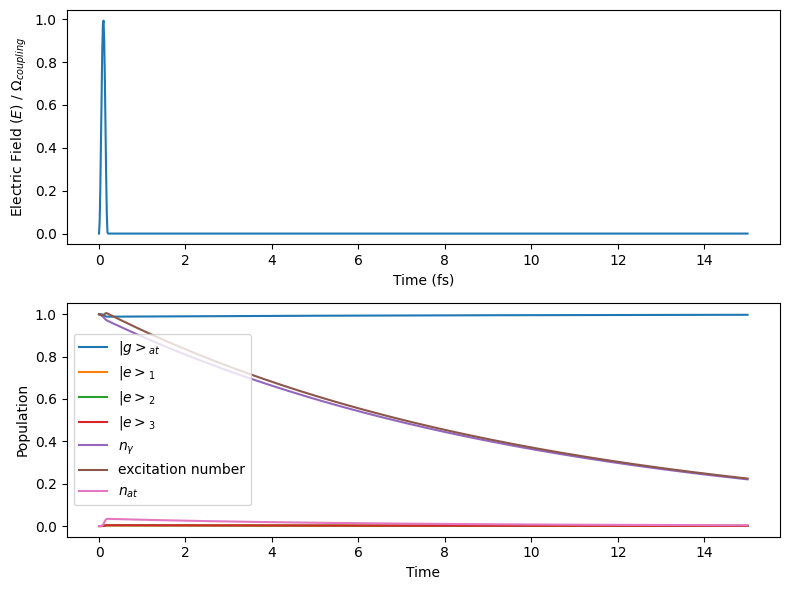

In [367]:
#
# VIZUALIZE THE FIELD AS AN EXAMPLE
#
args = {
    'time': Delta_ts[1],
    'omega': omegas[1],
    'Delta': Delta_ts[1],
    'E0': Omegas_c[1]
}
times_test = np.linspace(0,15, 1000)
E_t = [El_field(t, args) / Omega_coupling for t in times_test]
result = mesolve(H, psiini, times_test, c_ops = c_op_list, e_ops = e_op_list, args = args)#, options={"store_states": True})
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(times_test, E_t)
ax[0].set_xlabel("Time (fs)")
ax[0].set_ylabel("Electric Field ($E$) / $\Omega_{coupling}$")
for i, e_op_expect in enumerate(result.expect):
    if i == 0:
        label = r"$|g>_{at}$"
    elif i < N_atoms + 1:
        label = f"$|e>_{i}$"
    elif i == N_atoms + 1:
        label = r"$n_{\gamma}$"
    else:
        label = r"$n_{at}$"
        ax[1].plot(times_test, result.expect[i-1] + result.expect[i], label = "excitation number")
    ax[1].plot(times_test, result.expect[i], label=label)
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Population")
ax[1].legend()
plt.tight_layout()
plt.show()

<>:43: SyntaxWarning: invalid escape sequence '\O'
<>:43: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipykernel_164009/3712953388.py:43: SyntaxWarning: invalid escape sequence '\O'
  ax1.set_ylabel("Electric Field ($E$) / $\Omega_{coupling}$")


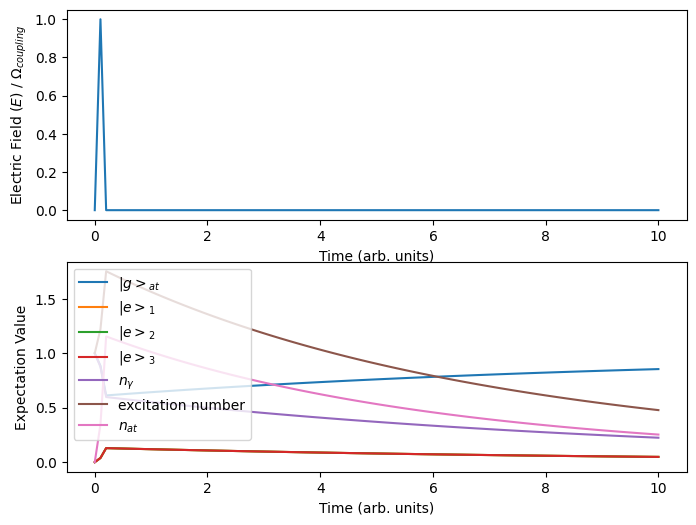

In [352]:
#
# PREPROCESSING
#
# Phase cycling
phases = [0]#[i * np.pi/2 for i in range(4)]
data_dict_stage1 = {}
for phi in phases:
    data_dict_stage1[phi] = {}
#
# CALCULATIONS
#

# (first laser pulse)
times_0 = times

# Iterate over the phi values
for phi in data_dict_stage1:
    args_0 = {
        'time': Delta_ts[0],  # t0 value = Delta value such that the pulse immediatley starts
        'omega': omegas[0],  # omega value
        'Delta': Delta_ts[0], # The width should be
        'E0': Omegas_c[0]  # E0 value
    }
    # Solve the system using mesolve (first laser pulse)
    result_0 = mesolve(H, psiini, times_0, c_ops=c_op_list, e_ops=e_op_list, args=args_0, options=options)

    current_dict = {}

    for i in range(len(times_0)): # save only the states that make sense
        if (2 * Delta_ts[0] <= times_0[i] <= last_pulse - 2 * (Delta_ts[1] + Delta_ts[2])):
            current_dict[i] = result_0.states[i]  # tau is indirectly stored in the index i (key of the dictionary)

    if current_dict:  # Check if the dictionary is not empty
        data_dict_stage1[phi] = current_dict

#
# PLOT TO CHECK the evolution
#

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.plot(times_0, [El_field(t, args_0)/Omega_coupling for t in times_0])
ax1.set_xlabel("Time (arb. units)")
ax1.set_ylabel("Electric Field ($E$) / $\Omega_{coupling}$")
for i in range(len(result_0.expect)):
    if i == 0:
        label = r"$|g>_{at}$"
    elif i < N_atoms + 1:
        label = f"$|e>_{i}$"
    elif i == N_atoms + 1:
        label = r"$n_{\gamma}$"
    else:
        label = r"$n_{at}$"
        ax2.plot(times_0, result_0.expect[i-1] + result_0.expect[i], label = "excitation number")
    ax2.plot(times_0, result_0.expect[i], label=label)
ax2.set_xlabel("Time (arb. units)")
ax2.set_ylabel("Expectation Value")
ax2.legend()
plt.show()

<>:33: SyntaxWarning: invalid escape sequence '\O'
<>:33: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipykernel_164009/1745011647.py:33: SyntaxWarning: invalid escape sequence '\O'
  ax1.set_ylabel("Electric Field ($E$) / $\Omega_{coupling}$")


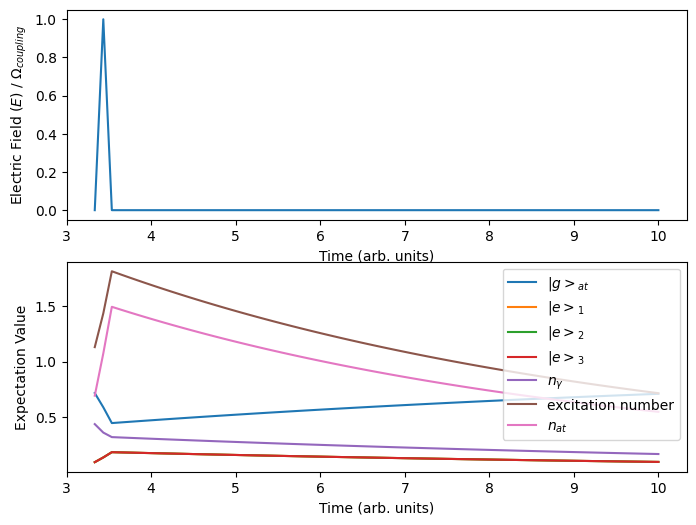

In [353]:
# (second laser pulse)
data_dict_stage2 = {}

# Iterate over the phi values
for phi, dic in data_dict_stage1.items():
    data_dict_stage2[phi] = {}  # Stage 2 copy of the phase
    # Iterate over the tau values and states after tau, from there make the second laser pulse
    for i, psiini_1 in dic.items():
        times_1 = times[i:]
        args_1 = {
            'time': times_1[0] + Delta_ts[1],
            'omega': omegas[1],
            'Delta': Delta_ts[1],
            'E0': Omegas_c[1]
        }
        # Solve the system using mesolve (second laser pulse)
        result_1 = mesolve(H, psiini_1, times_1, c_ops=c_op_list, e_ops=e_op_list, args=args_1, options=options)

        current_dict = {}
        for j in range(len(times_1)): # save only the states that make sense
            if (times[i] + 2 * Delta_ts[1] <= times_1[j] <= last_pulse - 2 * Delta_ts[2]):
                current_dict[j] = result_1.states[j] # T is stored in the information j, together with i

        if current_dict:  # Check if the dictionary is not empty
            data_dict_stage2[phi][i] = current_dict
        #
        # PLOT TO CHECK the evolution
        #
        if phi == 0 and i == time_steps//3:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
            ax1.plot(times_1, [El_field(t, args_1)/Omega_coupling for t in times_1])
            ax1.set_xlabel("Time (arb. units)")
            ax1.set_ylabel("Electric Field ($E$) / $\Omega_{coupling}$")
            for i in range(len(result_1.expect)):
                if i == 0:
                    label = r"$|g>_{at}$"
                elif i < N_atoms + 1:
                    label = f"$|e>_{i}$"
                elif i == N_atoms + 1:
                    label = r"$n_{\gamma}$"
                else:
                    label = r"$n_{at}$"
                    ax2.plot(times_1, result_1.expect[i-1] + result_1.expect[i], label = "excitation number")
                ax2.plot(times_1, result_1.expect[i], label=label)
            ax2.set_xlabel("Time (arb. units)")
            ax2.set_ylabel("Expectation Value")
            ax2.legend()
            plt.show()

# After processing each coherence time, you can optionally print the current state of the dictionary
#pprint.pprint(data_dict_stage2)

<>:54: SyntaxWarning: invalid escape sequence '\O'
<>:54: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipykernel_164009/1058766815.py:54: SyntaxWarning: invalid escape sequence '\O'
  ax1.set_ylabel("Electric Field ($E$) / $\Omega_{coupling}$")


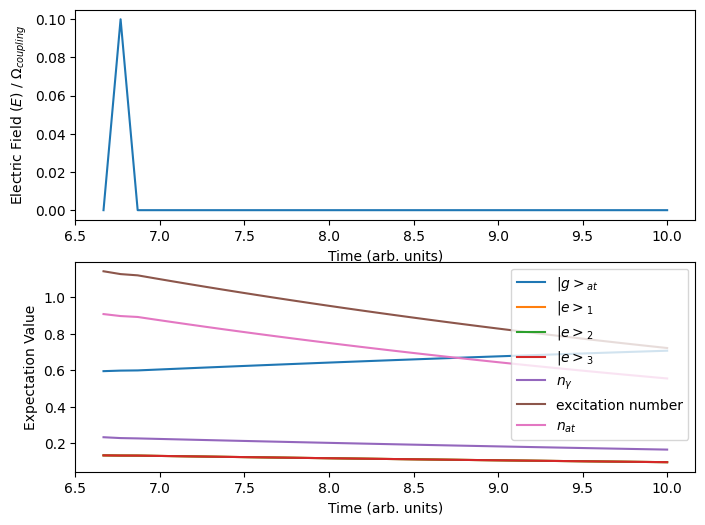

In [354]:
# (third laser pulse)
data_dict = {}

# Iterate over the phi values
for phi, dic in data_dict_stage2.items():
    if phi not in data_dict:
        data_dict[phi] = {}

    # Iterate over the tau values
    for i, dic1 in dic.items():
        times_1 = times[i:]

        # Iterate over the T values and make the last laser pulse
        for j, psiini_2 in dic1.items():

            times_2 = times_1[j:]
            args_2 = {
                'phi': 0,       #last pulse has no phase kick
                'time': times_2[0] + Delta_ts[2],  # Duration for the 2nd pulse
                'omega': omegas[2],  # Omega for the 2nd pulse
                'Delta': Delta_ts[2],  # Delta for the 2nd pulse
                'E0': Omegas_c[2]  # E0 for the 2nd pulse
            }

            # (last laser pulse)
            result_2 = mesolve(H, psiini_2, times_2, c_ops=c_op_list, e_ops=e_op_list, args=args_2, options=options)

            # Iterate over the states in result_2 and store the ones that meet:
            # ONLY the first state with T >= times_2[0] + 2 Delta_ts[2] is important -> break
            for k in range(len(times_2)):
                if (times_1[j] + 2 * Delta_ts[2] <= times_2[k] <= last_det_t):
                    waiting_time_j = times_1[j] - times_0[i] + Delta_ts[2] - Delta_ts[1]
                    T = truncate_number(waiting_time_j, tolerance-2) # Round to tolearance decimal places carefull!
                    T = j
                    if T not in data_dict[phi]:
                        data_dict[phi][T] = {}

                    coherence_time_i = times_0[i] + Delta_ts[1] - Delta_ts[0]
                    tau = truncate_number(coherence_time_i, tolerance-2) # Round to tolearance decimal places carefull!
                    tau = i

                    if tau not in data_dict[phi][T]:
                        data_dict[phi][T][tau] = []

                    # store the final time and the final state
                    detection_time_k = truncate_number(times_2[k] - times_2[0], tolerance-2)
                    t = k
                    data_dict[phi][T][tau].append((t, result_2.states[k], waiting_time_j, coherence_time_i, detection_time_k)) # Round to tolearance decimal places carefull!

            if phi == 0 and i == time_steps//3 and j == time_steps//3:
                fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
                ax1.plot(times_2, [El_field(t, args_2)/Omega_coupling for t in times_2])
                ax1.set_xlabel("Time (arb. units)")
                ax1.set_ylabel("Electric Field ($E$) / $\Omega_{coupling}$")
                for i in range(len(result_2.expect)):
                    if i == 0:
                        label = r"$|g>_{at}$"
                    elif i < N_atoms + 1:
                        label = f"$|e>_{i}$"
                    elif i == N_atoms + 1:
                        label = r"$n_{\gamma}$"
                    else:
                        label = r"$n_{at}$"
                        ax2.plot(times_2, result_2.expect[i-1] + result_2.expect[i], label = "excitation number")
                    ax2.plot(times_2, result_2.expect[i], label=label)
                ax2.set_xlabel("Time (arb. units)")
                ax2.set_ylabel("Expectation Value")
                ax2.legend()
                plt.show()
#pprint.pprint(data_dict)
# The final data_dict will now contain the results for each φ, τ, and T

In [355]:
#
# POST-PROCESSING
#

# Create an empty dictionary `accumulated_data` to store lists of (\psi) for each ((\tau, T, t)):
averaged_data_dict = {}
for T, tau_dict in data_dict[phases[0]].items():
    if T not in averaged_data_dict:
        averaged_data_dict[T] = {}
    for tau, T_list in tau_dict.items():
        if tau not in averaged_data_dict[T]:
            averaged_data_dict[T][tau] = {}

        for t, psi_mean, _, _, _ in T_list:
            if t not in averaged_data_dict[T][tau]:
                averaged_data_dict[T][tau][t] = None

            for phi in data_dict.keys():
                for T1 in data_dict[phi].keys():
                    if T1 == T:
                        for tau1 in data_dict[phi][T1].keys():
                            if tau1 == tau:
                                for t1, psi1, _, _, _  in data_dict[phi][T1][tau1]:
                                    if t1 == t:
                                        psi_mean += psi1
                                    continue
                            continue
                    continue
            expect_val = expect(I, psi_mean.unit()) / omega_c
            averaged_data_dict[T][tau][t] = expect_val

# <psi | Interaction_Op | psi> =/= 0, while <psi | Dip_op | psi> == 0 :( TODO
#averaged_data_dict[2]

In [356]:
#
# PREPARE FOR PLOTTING
#
T_dictionary = {}

for T in averaged_data_dict.keys():  # Extract all unique T values
    taus = np.array(list(averaged_data_dict[T].keys()))
    ts = np.array(sorted(set(t for tau in taus for t in averaged_data_dict[T][tau].keys())))
    data = np.zeros((len(ts), len(taus)))  # or dtype=np.complex128 if needed
    # Populate the 2D data array with the corresponding expect_vals
    for i, t in enumerate(ts):  # Iterate over ts
        for j, tau in enumerate(taus):  # Iterate over taus
            # Check if the specific t exists for the given tau
            if t in averaged_data_dict[T][tau]:
                data[i, j] = averaged_data_dict[T][tau][t]  # Assign expect_val

    # Store T-specific results in the dictionary
    T_dictionary[T] = {
        "ts": ts,  # Local ts specific to T
        "taus": taus,  # Local taus specific to T
        "data": data,  # Smaller T-specific grid
    }

valid_indices = np.linspace(0, time_steps - 1, time_steps//3, dtype=int)  # Equally distributed indices

smallest_key = min(averaged_data_dict.keys())  # first T value gives biggest data-set

global_ts = np.array(T_dictionary[smallest_key]["ts"])  # Local taus for the current T
global_taus = np.array(T_dictionary[smallest_key]["taus"])  # Local taus for the current T

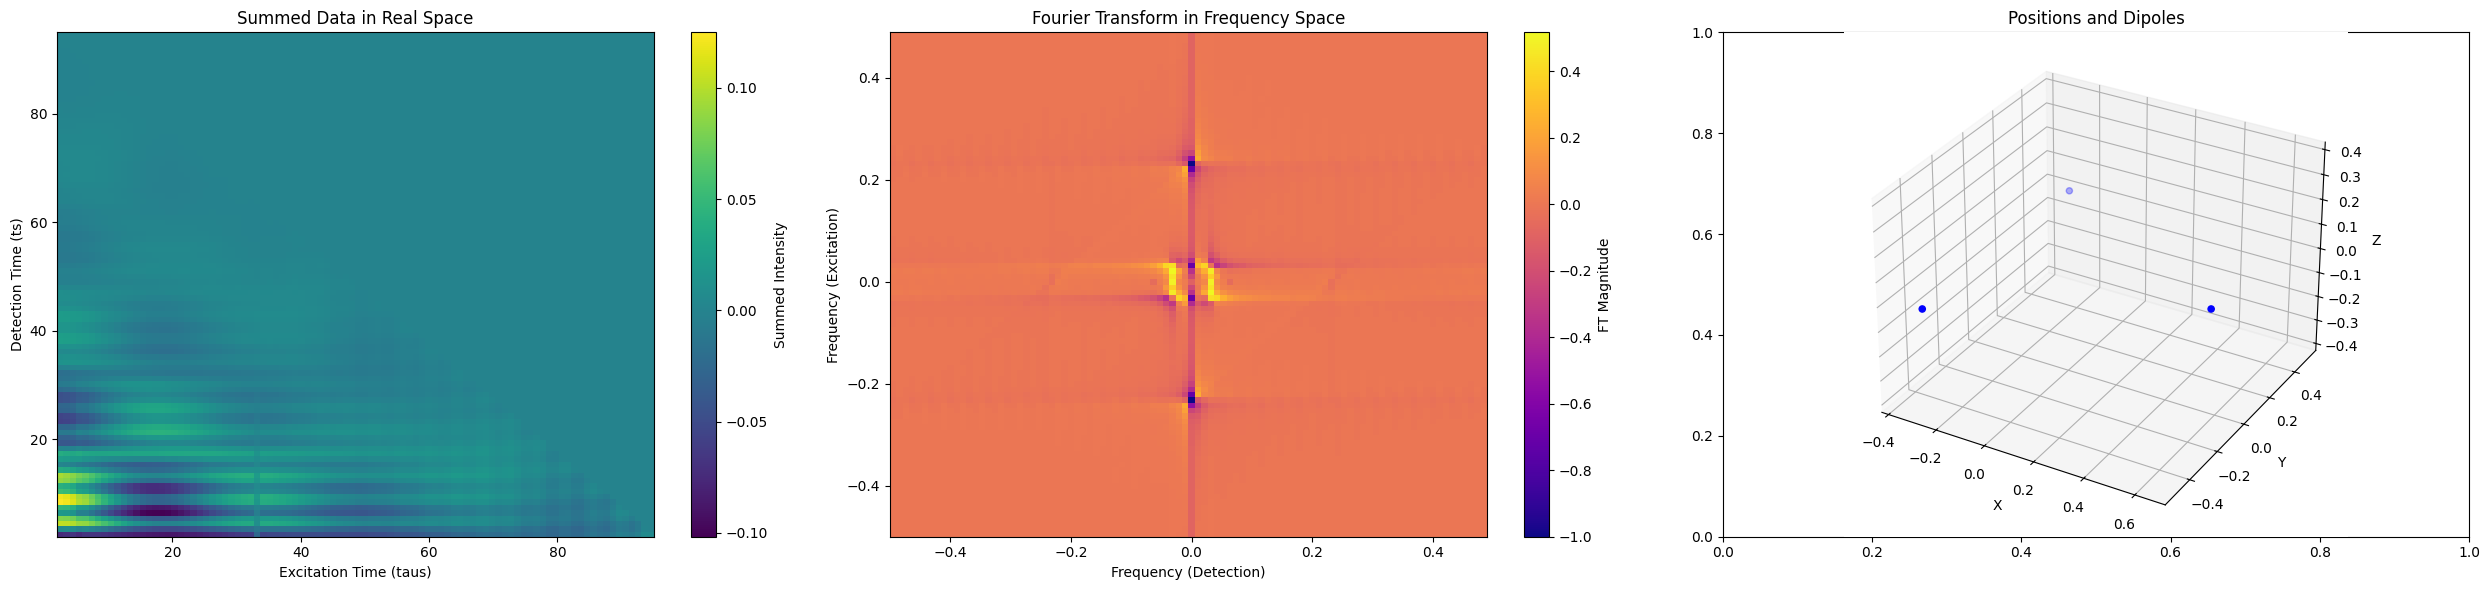

In [357]:
#
# PLOT THE WHOLE DATA AVG and its FT
#
# Sum all data into global sum
global_data = np.zeros((len(global_ts), len(global_taus)))

# Sum data for each temperature T in T_dictionary
for T, T_data in T_dictionary.items():
    ts = T_data["ts"]
    taus = T_data["taus"]
    data = T_data["data"]

    for i, t in enumerate(ts):
        for j, tau in enumerate(taus):
            global_i = np.where(global_ts == t)[0]  # Find the index of t in global_ts
            global_j = np.where(global_taus == tau)[0]
            global_data[global_i, global_j] += data[i, j]  # Accumulate (you can also do averaging if needed)
#max = np.max(np.abs(global_data))
global_data /= len(T_dictionary)

# Perform 2D Fourier Transform
ft_data = np.fft.fft2(global_data)
ft_data = np.fft.fftshift(ft_data)  # Shift zero frequency to the center
freq_ts = np.fft.fftshift(np.fft.fftfreq(len(global_ts), d=(global_ts[1] - global_ts[0])))
freq_taus = np.fft.fftshift(np.fft.fftfreq(len(global_taus), d=(global_taus[1] - global_taus[0])))

epsilon = 1e-10  # Small value to avoid division by zero
#ft_data = -freq_ts[:, np.newaxis] * np.imag(
#    ft_data / (freq_taus[:, np.newaxis] + epsilon))
ft_data = np.real(ft_data)
max = np.max(np.abs(ft_data))
ft_data /= max

fig, axs = plt.subplots(1, 3, figsize=(25, 6))

# Plot the global sum (2D plot) in the first subplot (axs[0])
extent = [np.min(global_taus), np.max(global_taus), np.min(global_ts), np.max(global_ts)]
im1 = axs[0].imshow(global_data, extent=extent, origin='lower', aspect='auto', cmap='viridis')
axs[0].set_title("Summed Data in Real Space")
axs[0].set_ylabel("Detection Time (ts)")
axs[0].set_xlabel("Excitation Time (taus)")
fig.colorbar(im1, ax=axs[0], label="Summed Intensity")

# Plot the Fourier Transform result (2D plot) in the second subplot (axs[1])
extent_ft = [np.min(freq_taus), np.max(freq_taus), np.min(freq_ts), np.max(freq_ts)]
im2 = axs[1].imshow(ft_data, extent=extent_ft, origin='lower', aspect='auto', cmap='plasma')
axs[1].set_title("Fourier Transform in Frequency Space")
axs[1].set_xlabel("Frequency (Detection)")
axs[1].set_ylabel("Frequency (Excitation)")
fig.colorbar(im2, ax=axs[1], label="FT Magnitude")
ax3d = fig.add_subplot(1, 3, 3, projection='3d')  # 3D plot in the third subplot
Pos = cyl_positions(distance, N_atoms, n_chains)
ax3d.scatter(Pos[:, 0], Pos[:, 1], Pos[:, 2], c='b', marker='o')
ax3d.set_xlabel('X')
ax3d.set_ylabel('Y')
ax3d.set_zlabel('Z')
ax3d.set_title('Positions and Dipoles')
ax3d.axis('equal')
plt.tight_layout()
file_name_combined = f"Cavity_REAL_+_FT_lam{fixed_lam:.1f}_alpha={alpha:.2f}_g_0{gamma_0:.2f}_g_phi{gamma_phi:.2f}_{n_rings}x{n_chains}_dist={distance:.2f}.svg"
save_path_combined = "/home/leopold/PycharmProjects/Master_thesis/Figures_From_Python/" + file_name_combined
#plt.savefig(save_path_combined)
plt.show()

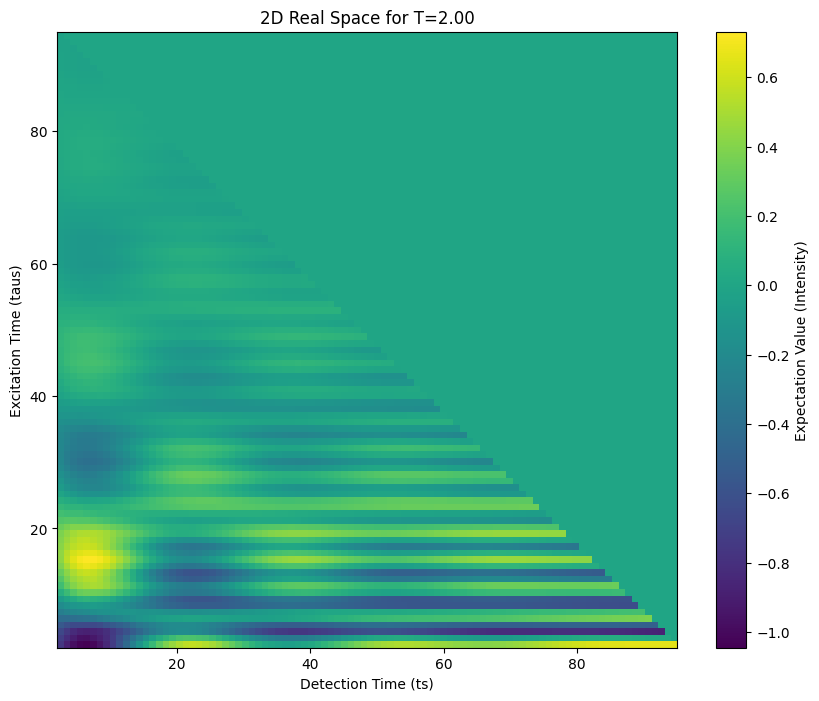

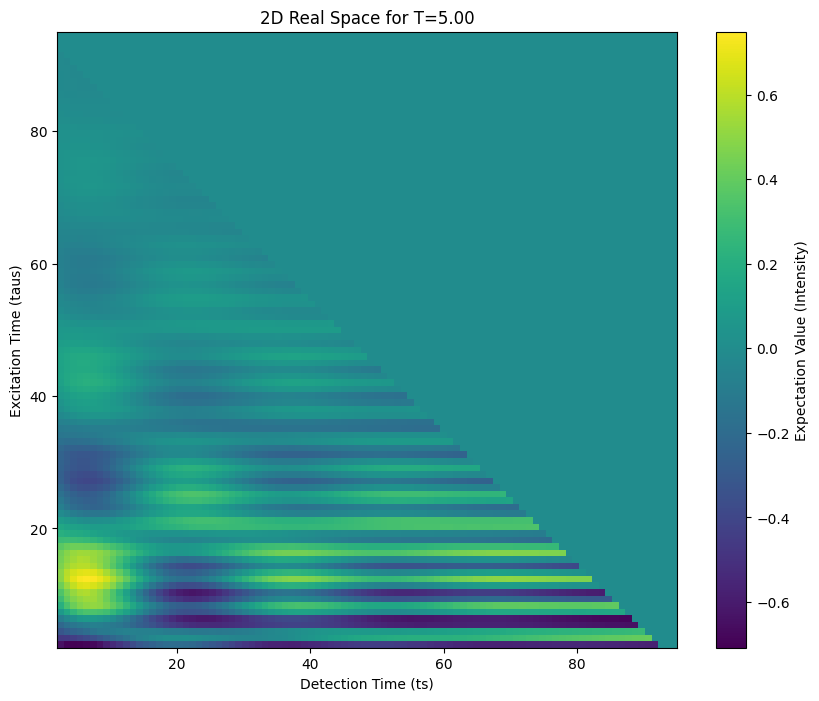

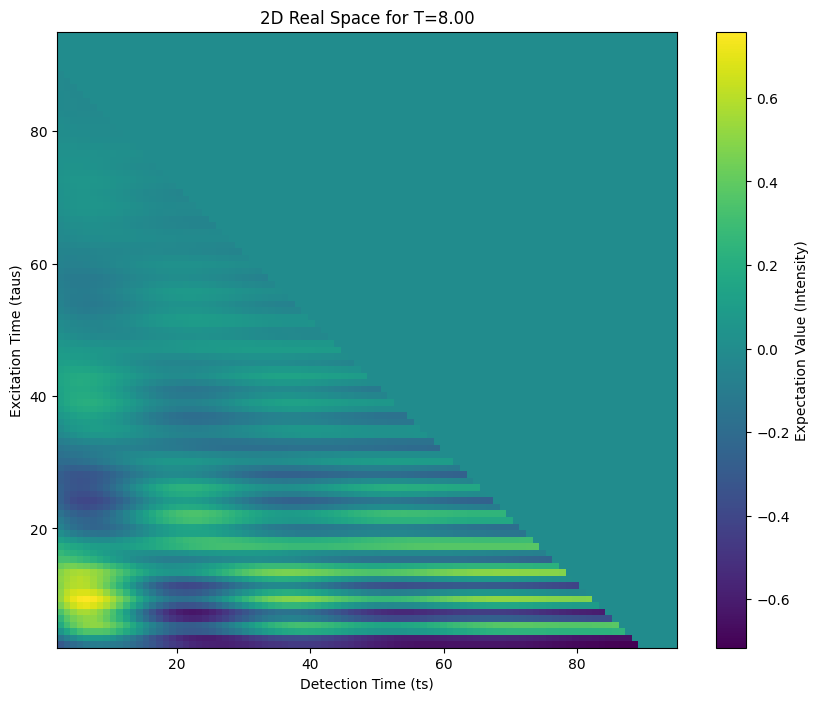

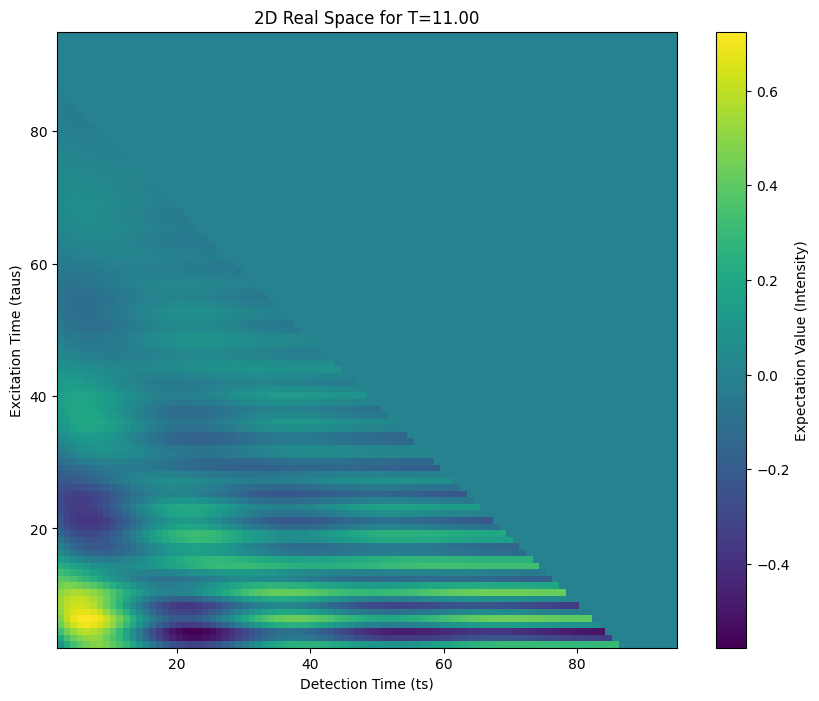

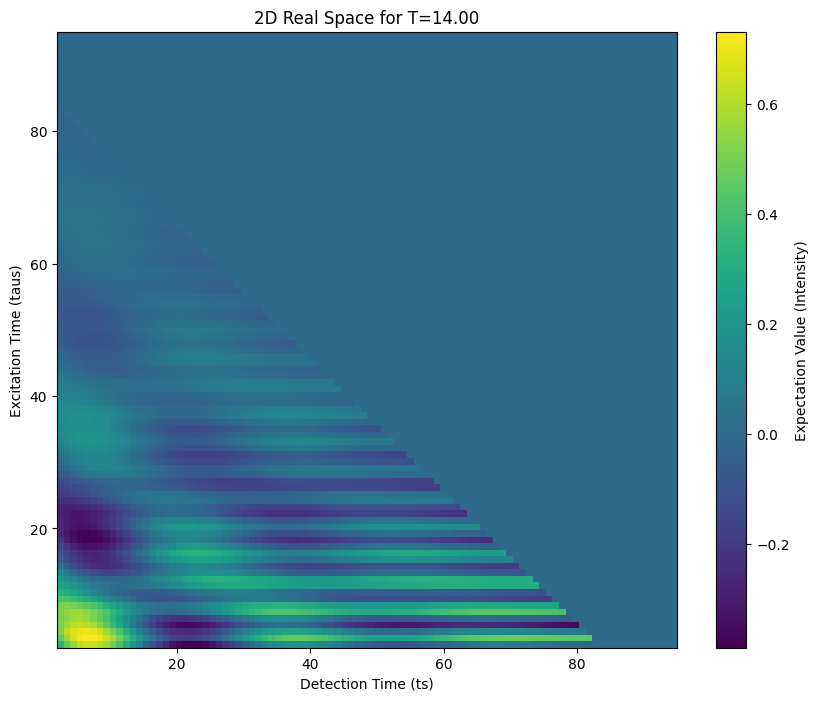

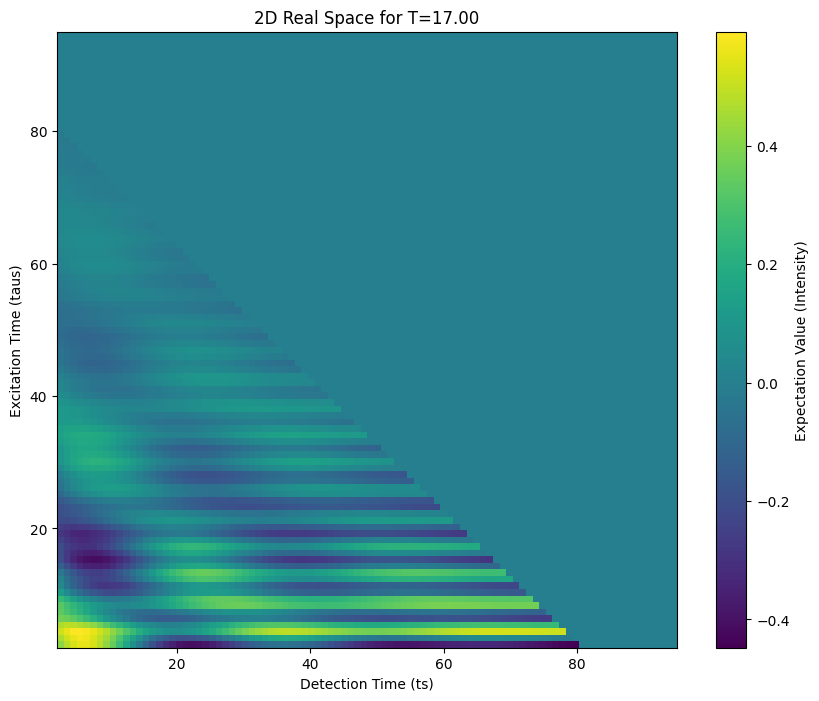

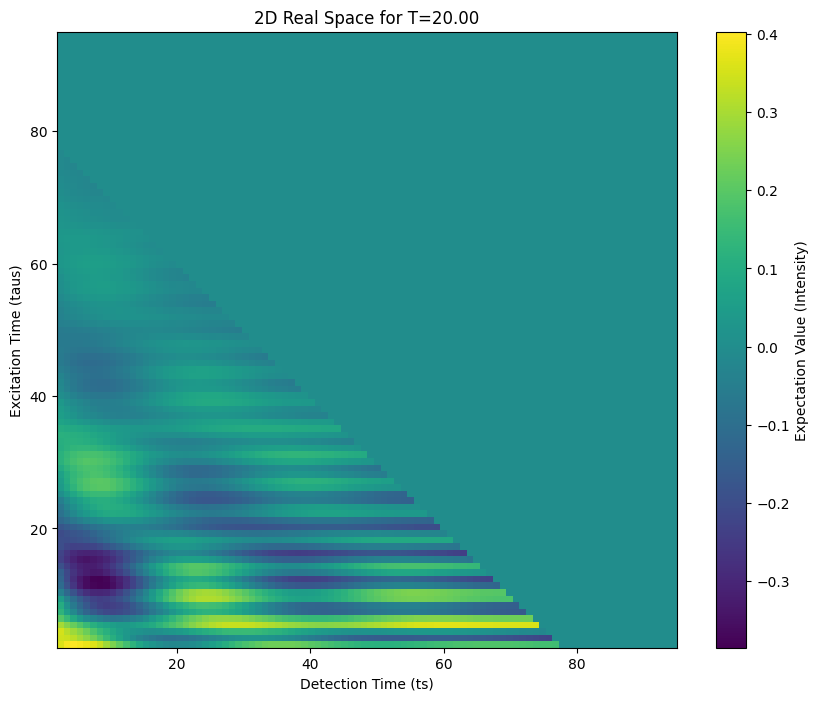

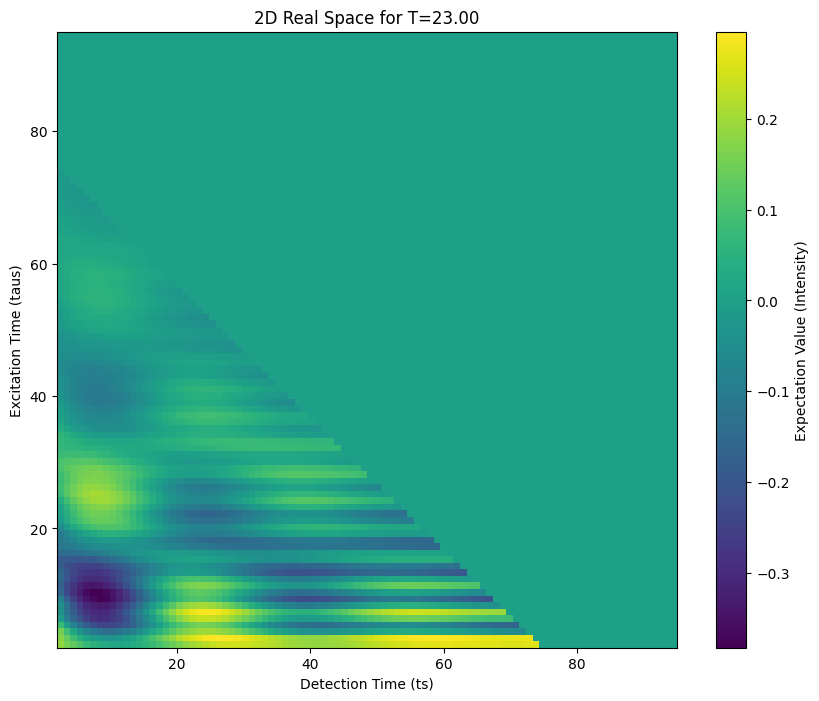

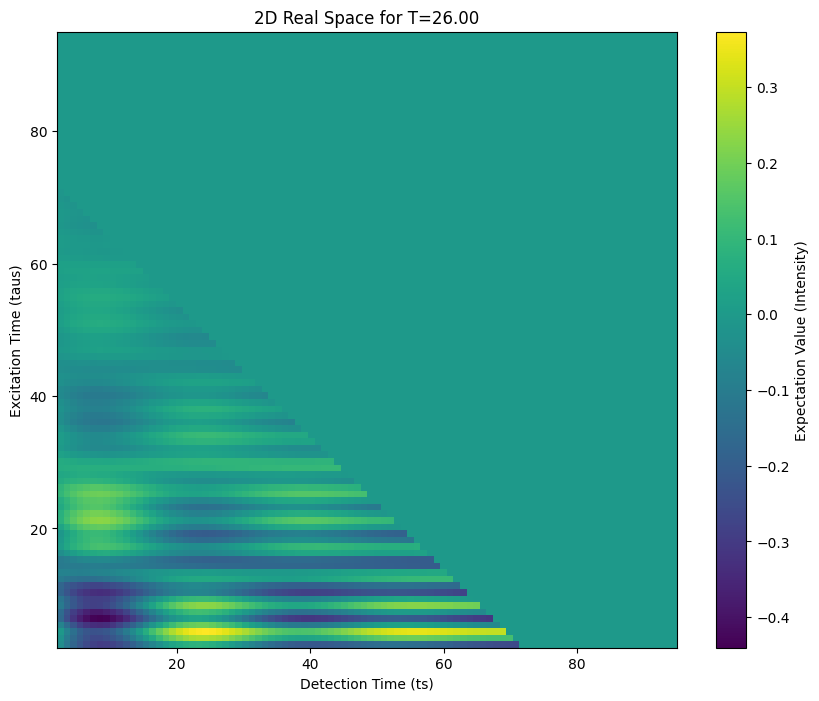

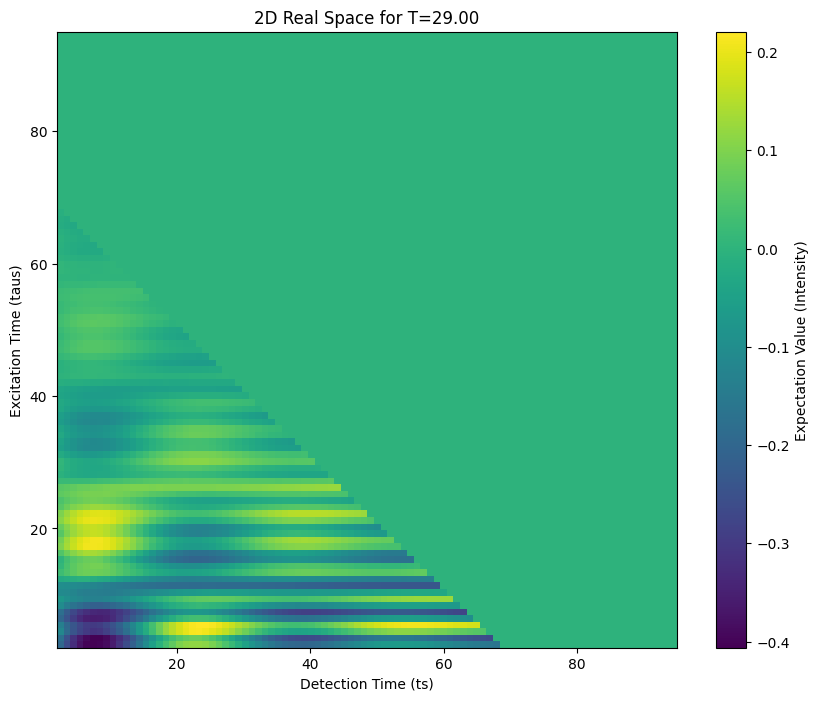

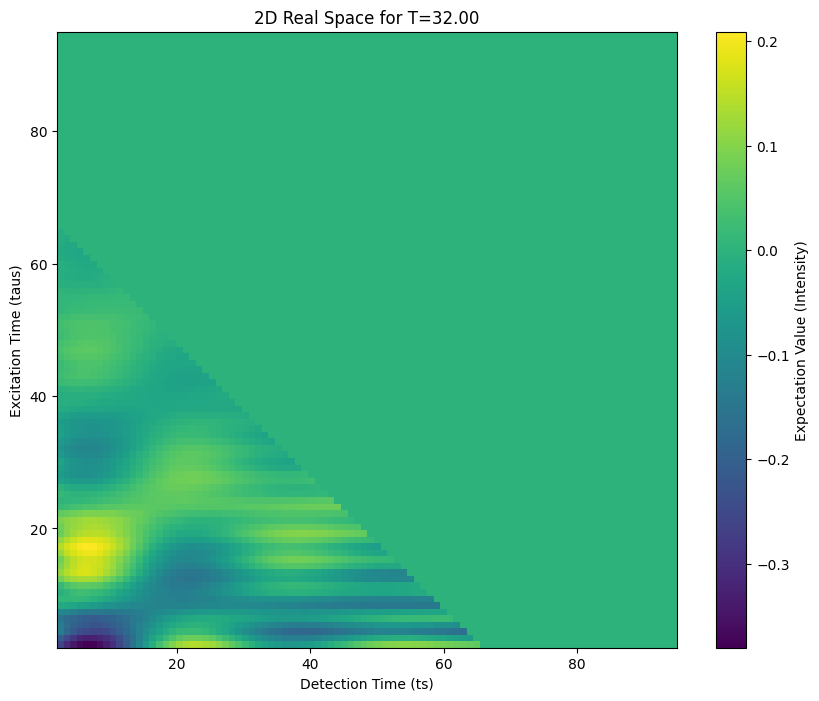

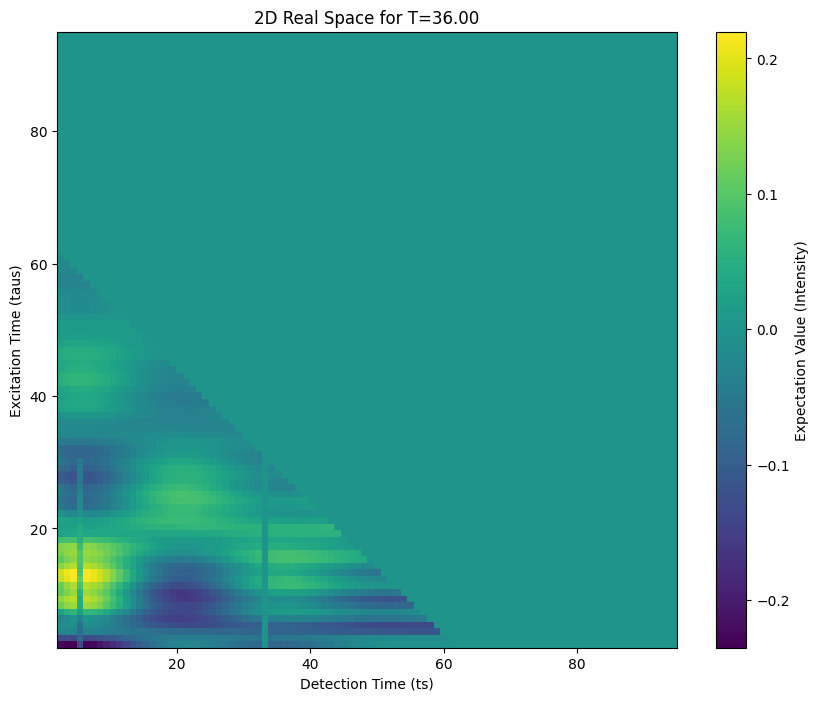

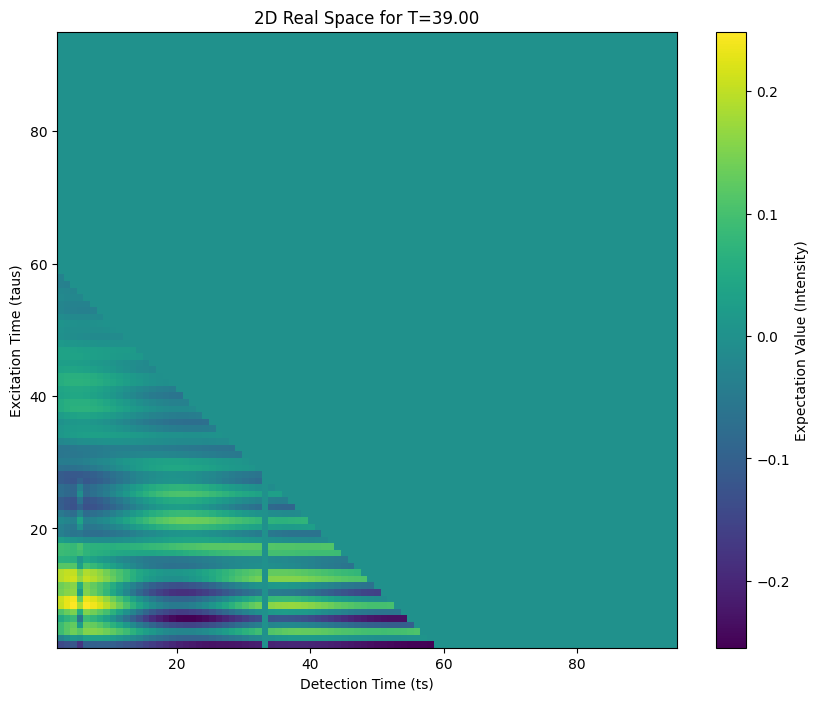

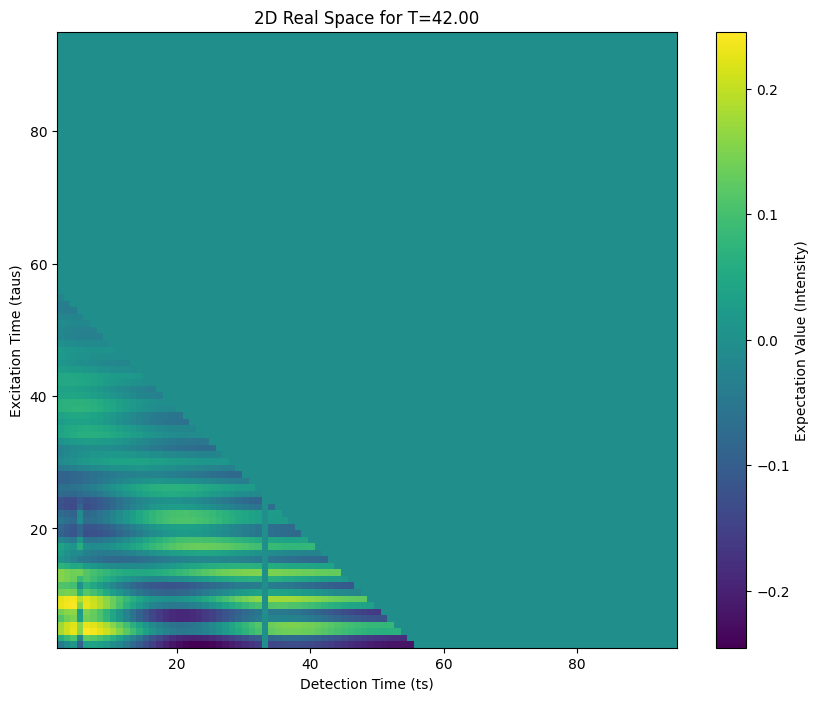

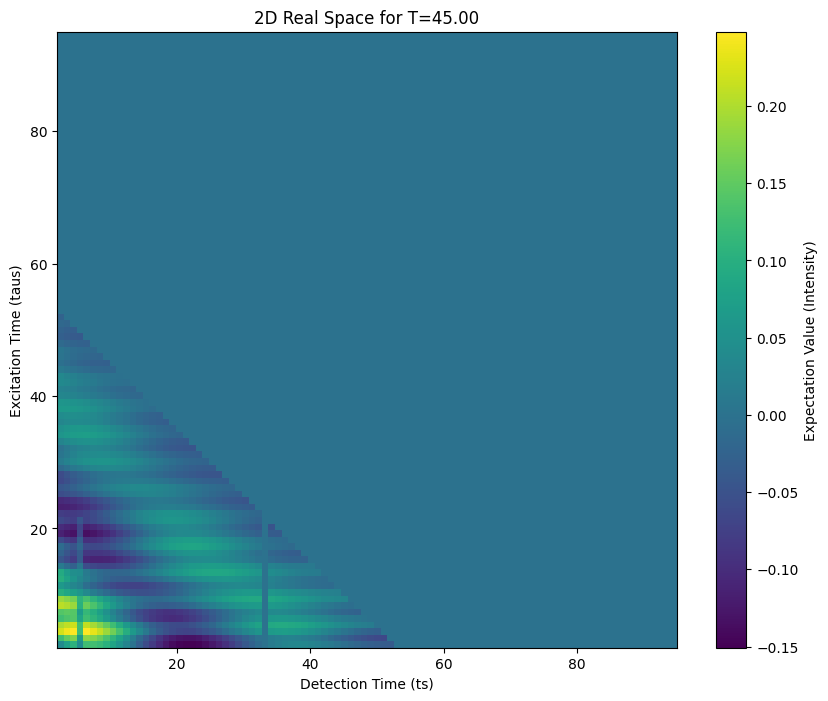

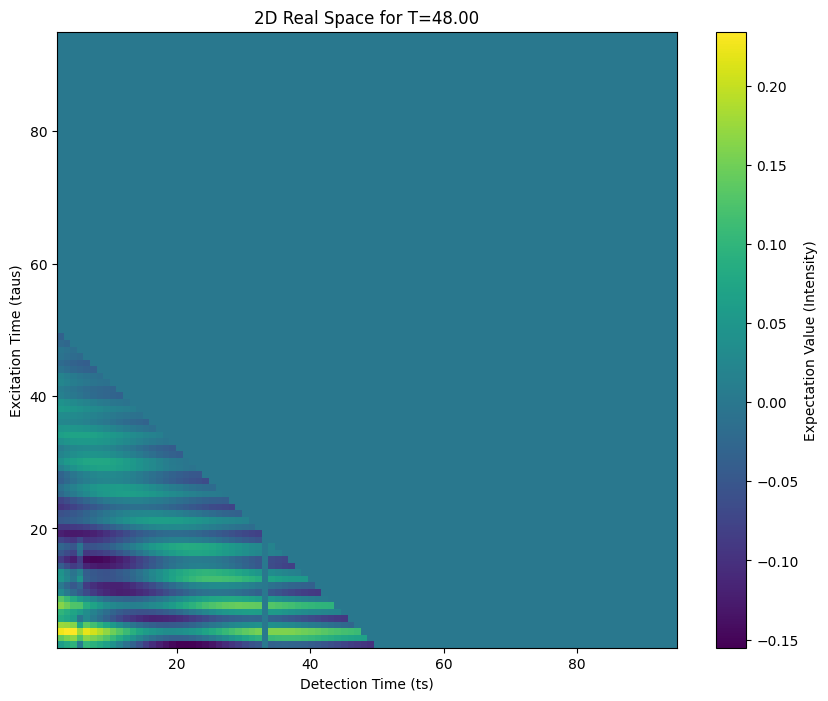

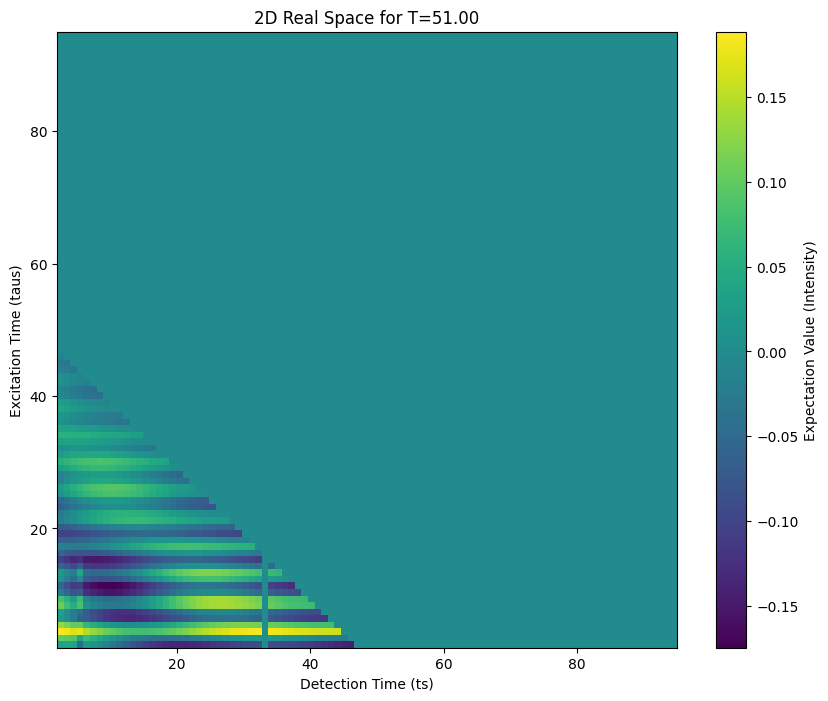

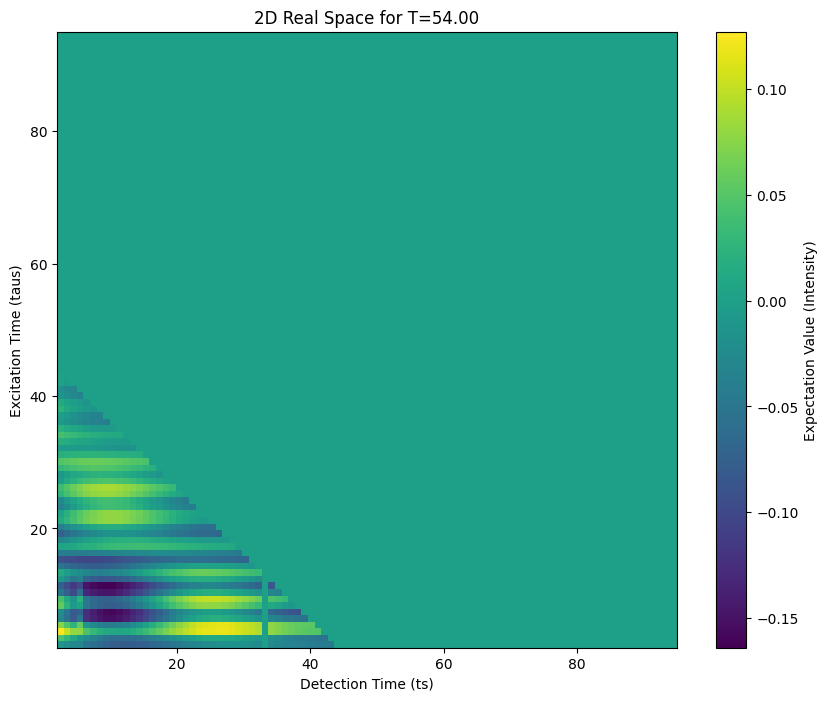

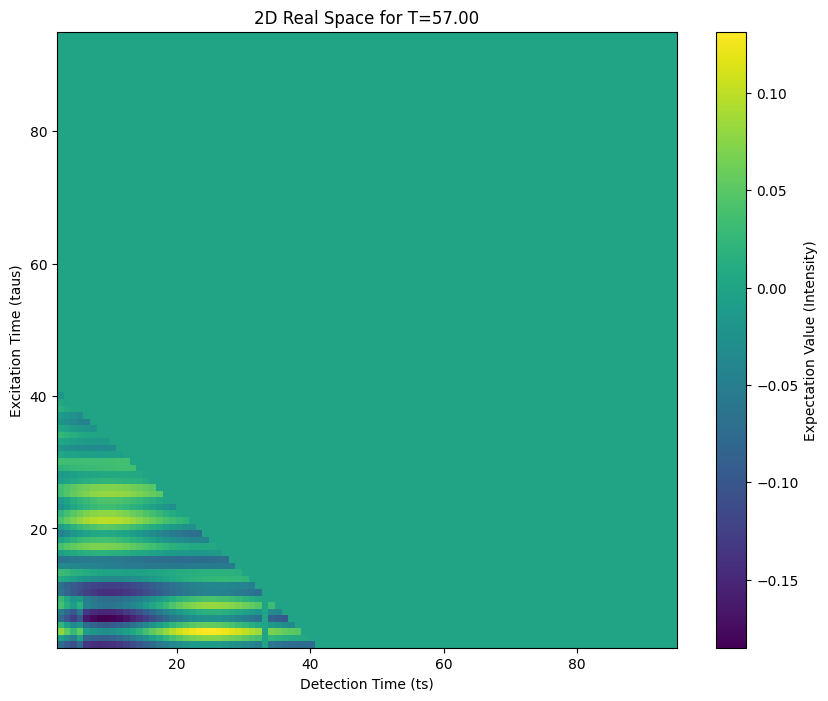

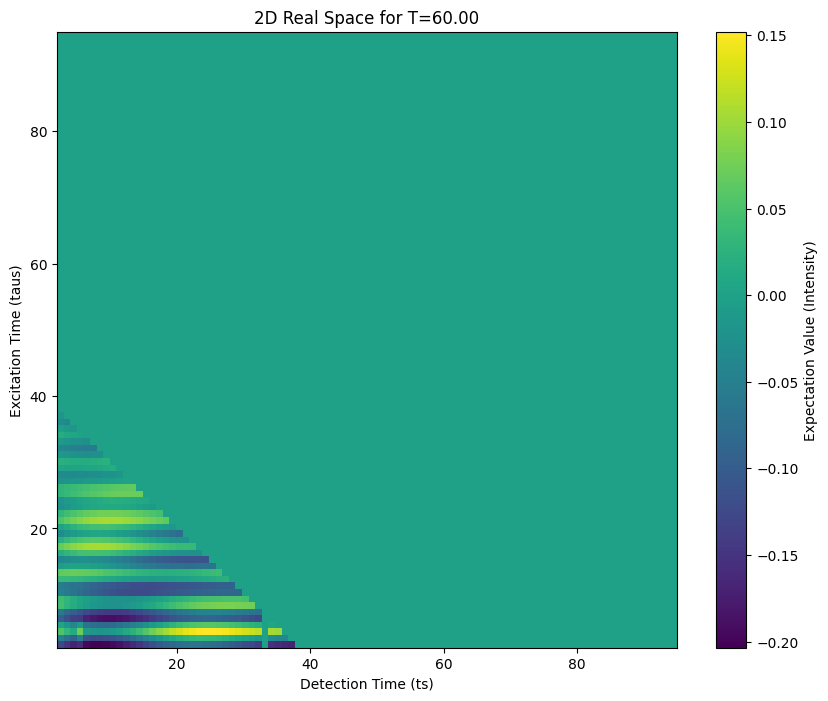

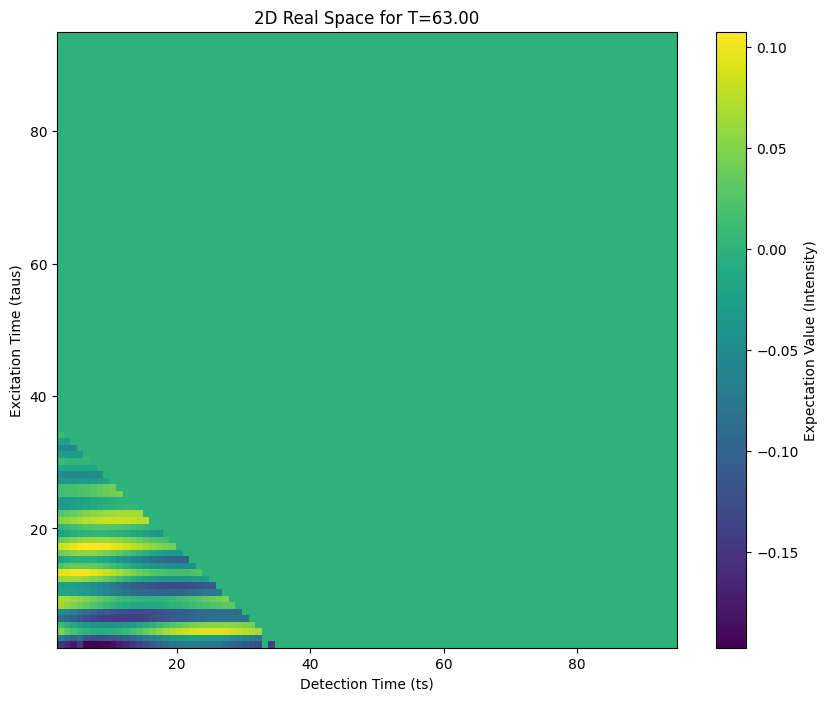

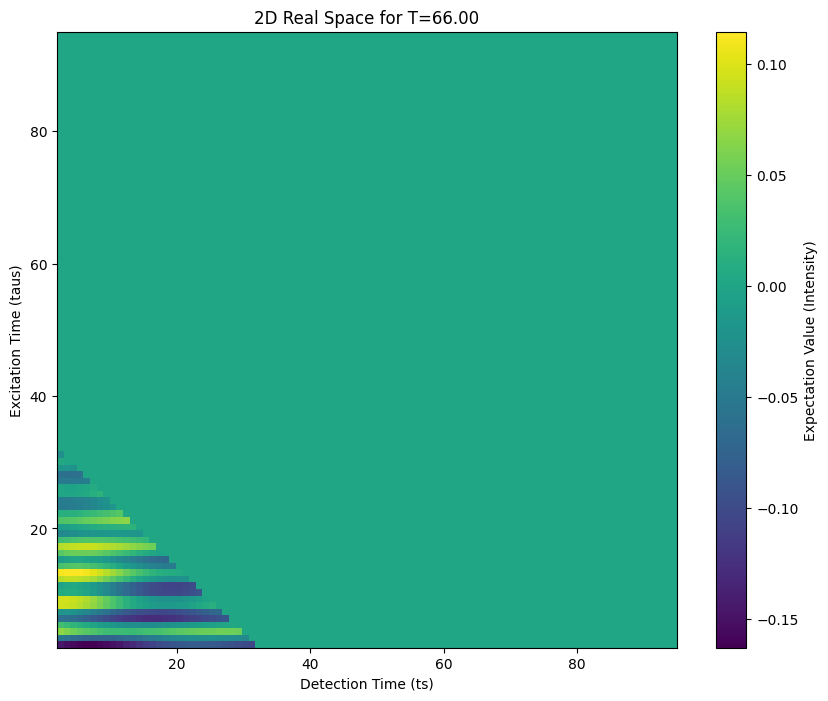

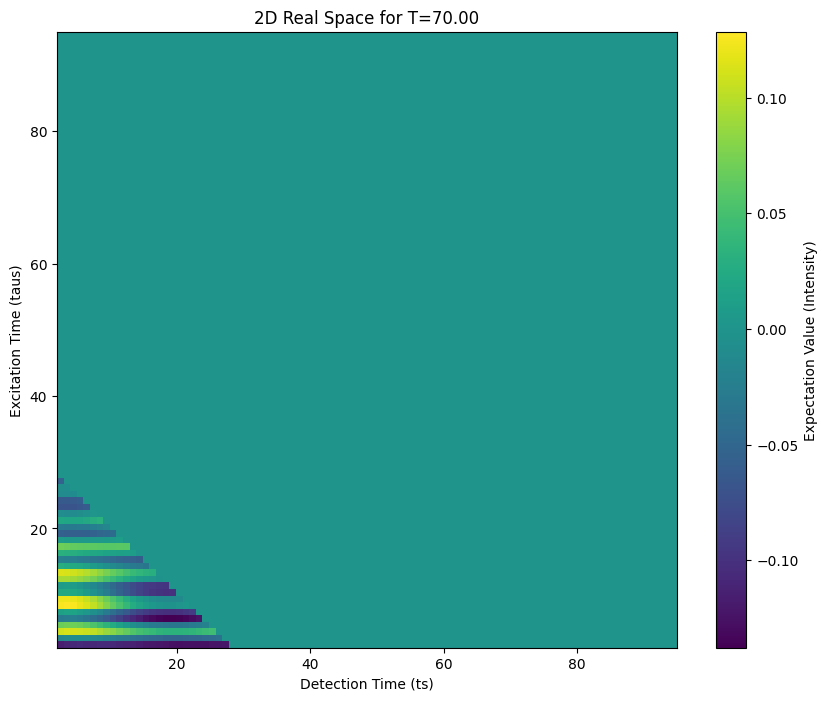

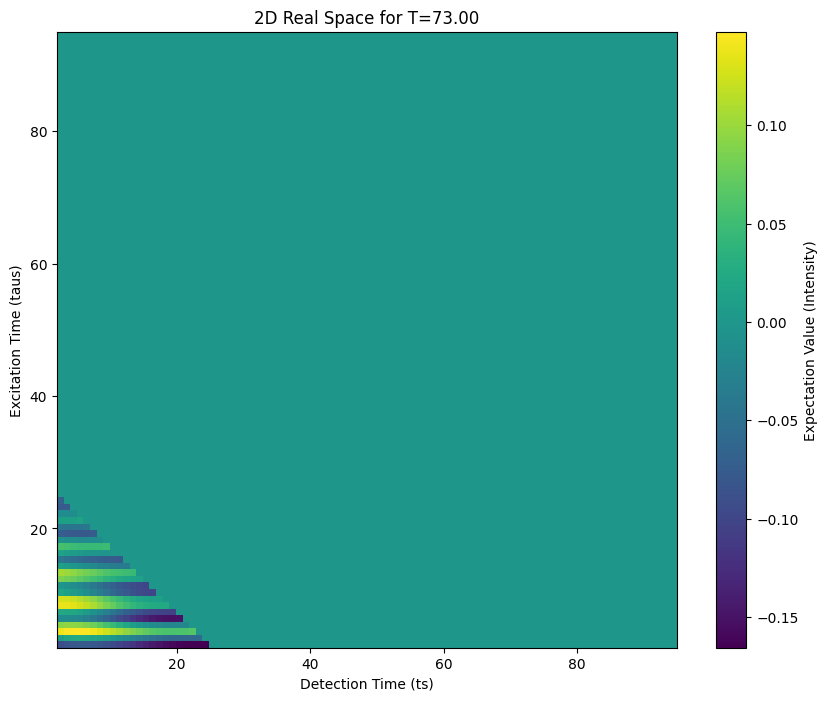

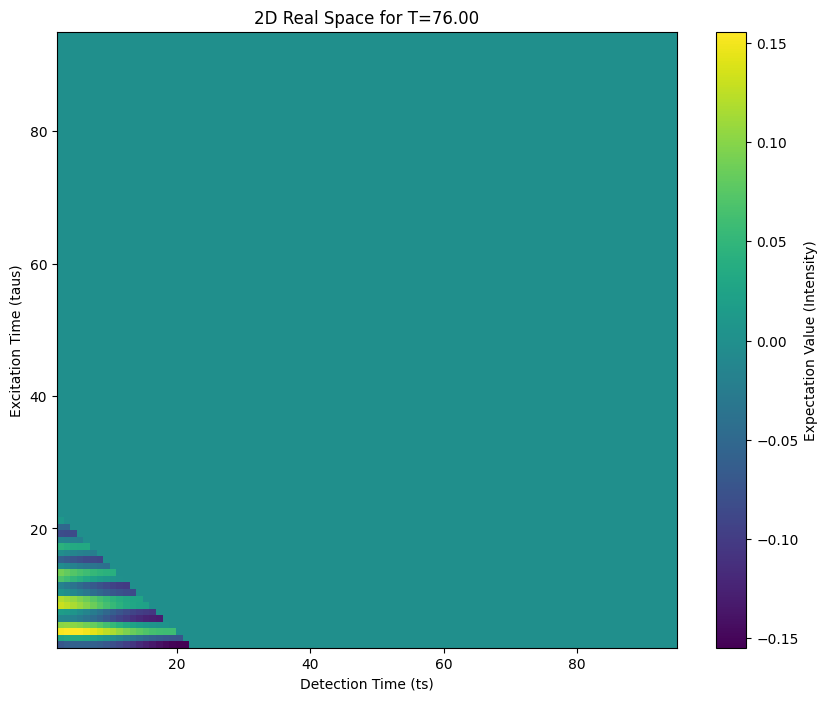

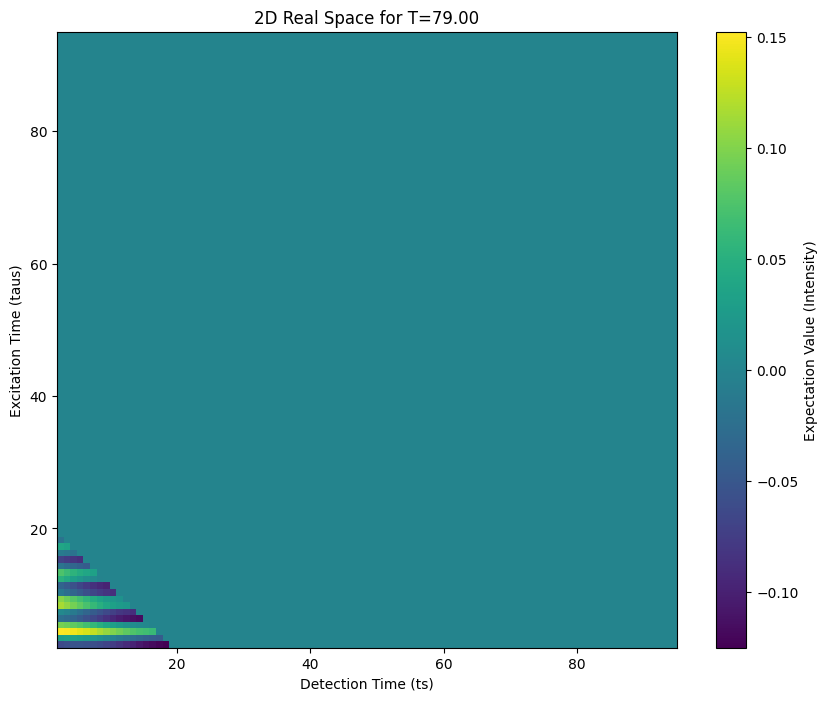

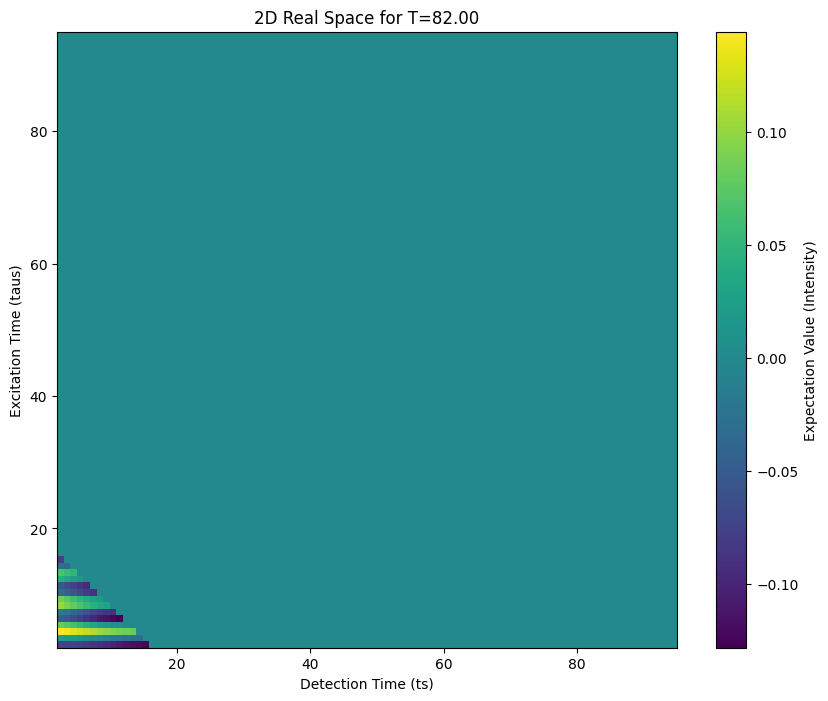

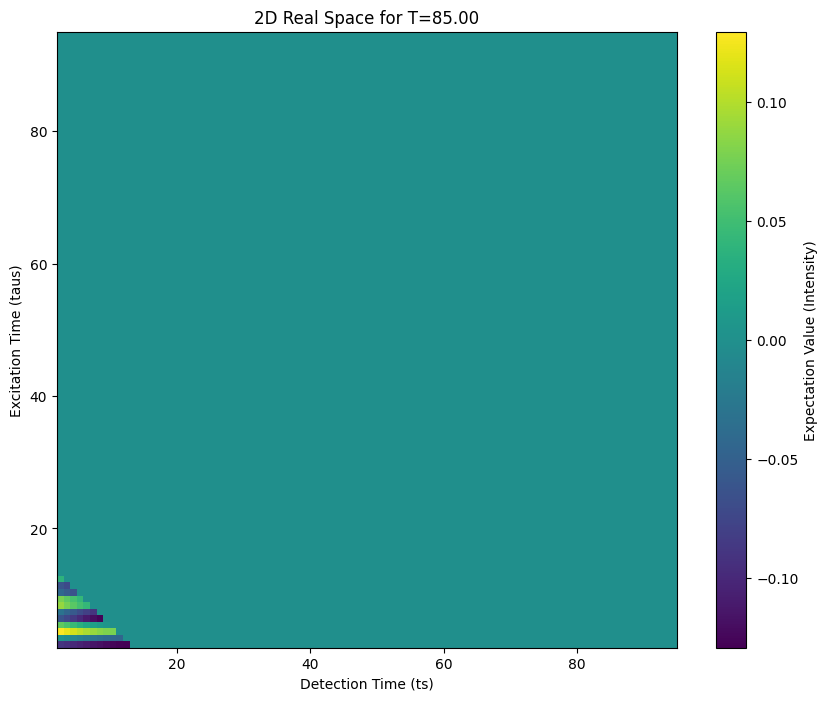

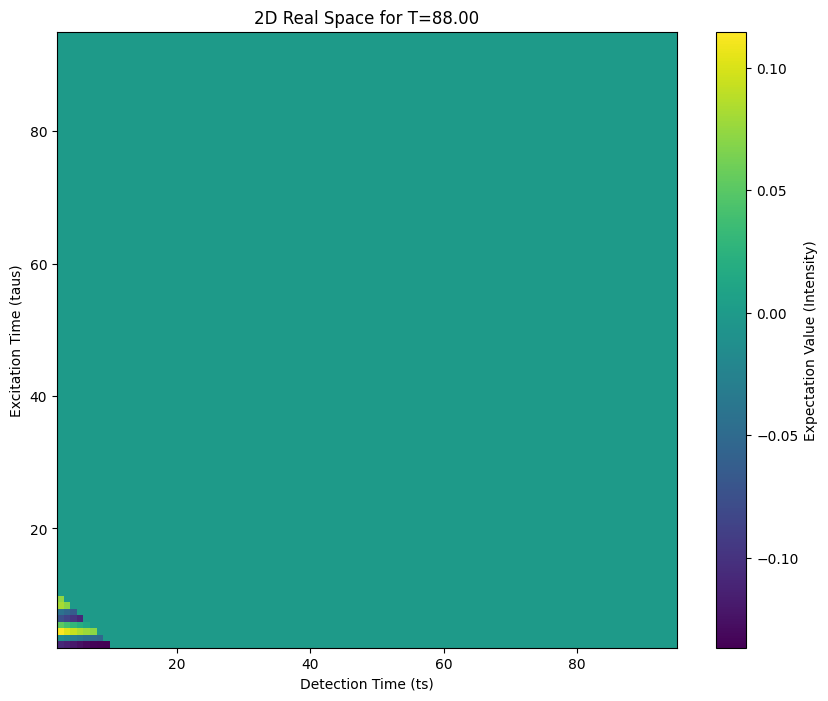

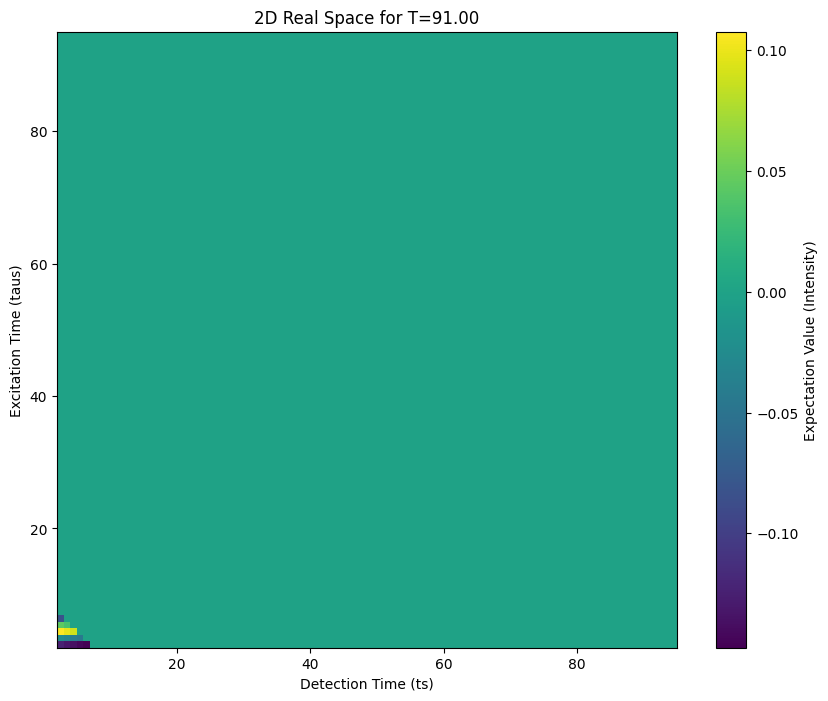

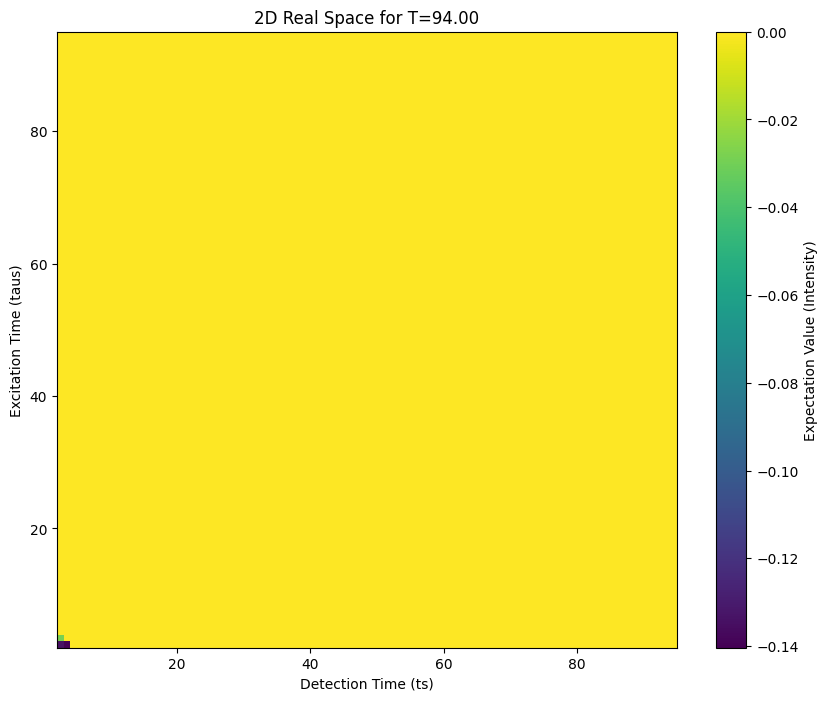

In [358]:
#
# PLOT THE TIME DIMENSIONS ON A GLOBAL GRID
#
T_dictionary_full = {} # save the extended time dim. data in new dict
for idx, (T, T_data) in enumerate(T_dictionary.items()):
    if idx not in valid_indices:  # Ensure only valid indices are selected
        continue
    # Extract data for the current T
    taus = T_data["taus"]  # Local taus for the current T
    ts = T_data["ts"]  # Local ts for the current T
    data = T_data["data"]  # Aligned 2D data
    if len(ts) < 2 or len(taus) < 2:  # Ensure only valid indices are selected
        continue

    # Initialize the global extended grid with zeros
    data_extended = np.zeros((len(global_ts), len(global_taus)))

    # Map taus and ts to global indices
    for i, t in enumerate(ts):
        for j, tau in enumerate(taus):
            global_i = np.where(global_ts == t)[0]  # Find the index of t in global_ts
            global_j = np.where(global_taus == tau)[0]
            data_extended[global_i, global_j] = data[i, j]  # Accumulate (you can also do averaging if needed)
    max = np.max(np.abs(data_extended))
    #data_extended /= max

    plt.figure(figsize=(10, 8))
    # Define extent for axis alignment (using the global ts and taus)
    extent = [global_ts[0], global_ts[-1], global_taus[0], global_taus[-1]]
    plt.imshow(data_extended, extent=extent, origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label="Expectation Value (Intensity)")
    plt.title(f"2D Real Space for T={T:.2f}")
    plt.xlabel("Detection Time (ts)")
    plt.ylabel("Excitation Time (taus)")
    plt.show()
    T_dictionary_full[T] = {"data": data_extended}
########################################################33333333 REAL SPACE END

<>:33: SyntaxWarning: invalid escape sequence '\o'
<>:34: SyntaxWarning: invalid escape sequence '\o'
<>:46: SyntaxWarning: invalid escape sequence '\o'
<>:47: SyntaxWarning: invalid escape sequence '\o'
<>:33: SyntaxWarning: invalid escape sequence '\o'
<>:34: SyntaxWarning: invalid escape sequence '\o'
<>:46: SyntaxWarning: invalid escape sequence '\o'
<>:47: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_164009/3166074178.py:33: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("$\omega_{exc}$ (arb. units)")  # Excitation frequency
/tmp/ipykernel_164009/3166074178.py:34: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("$\omega_{det}$ (arb. units)")  # Detection frequency
/tmp/ipykernel_164009/3166074178.py:46: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("$\omega_{exc}$ (arb. units)")
/tmp/ipykernel_164009/3166074178.py:47: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("$\omega_{det}$ (arb. units)")


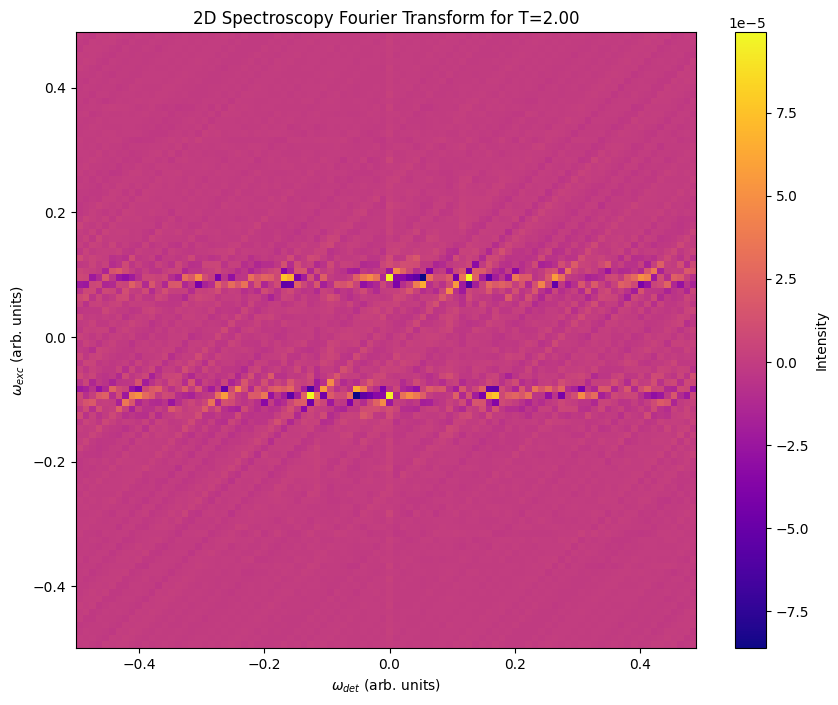

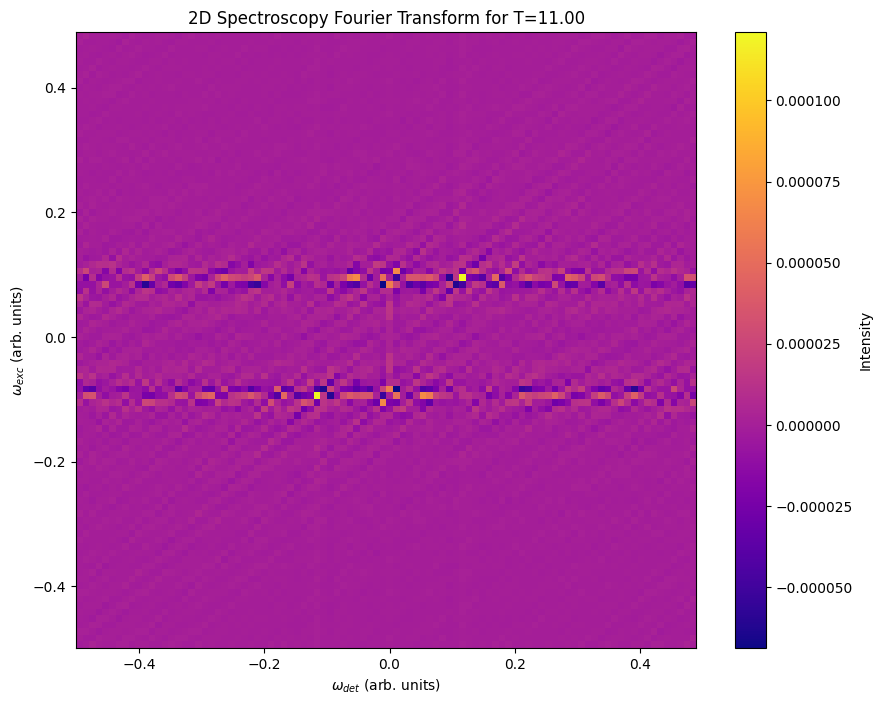

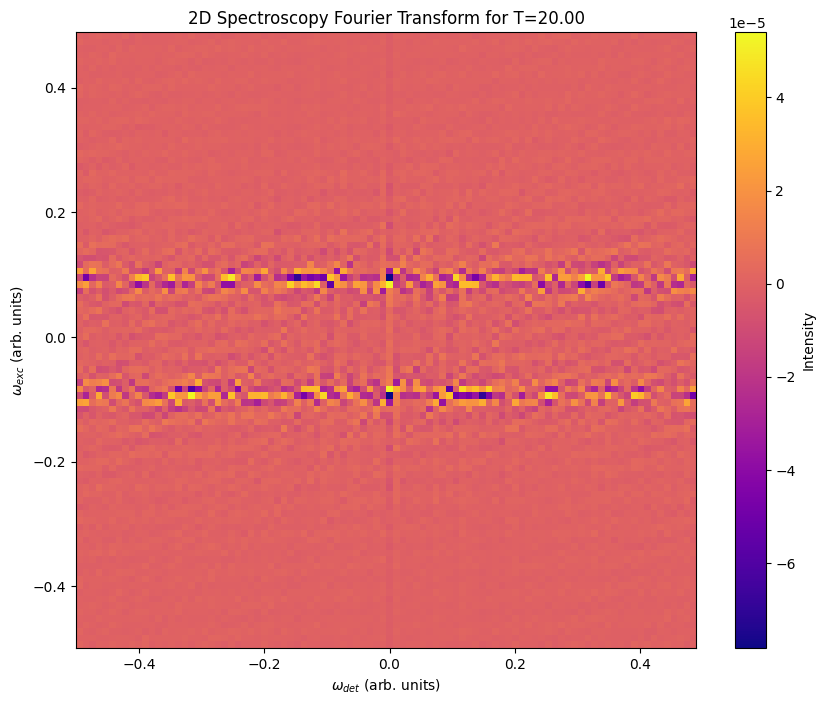

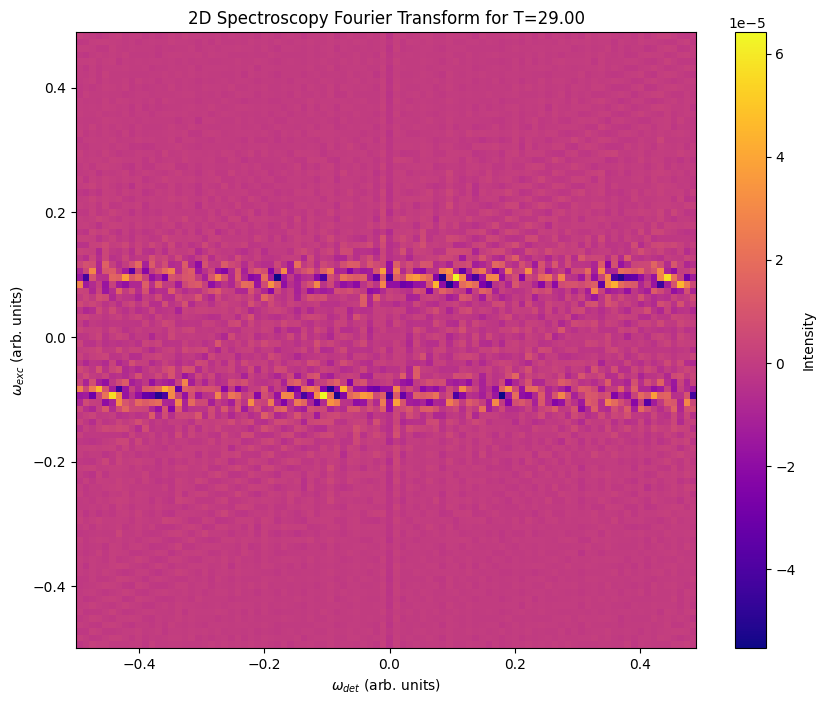

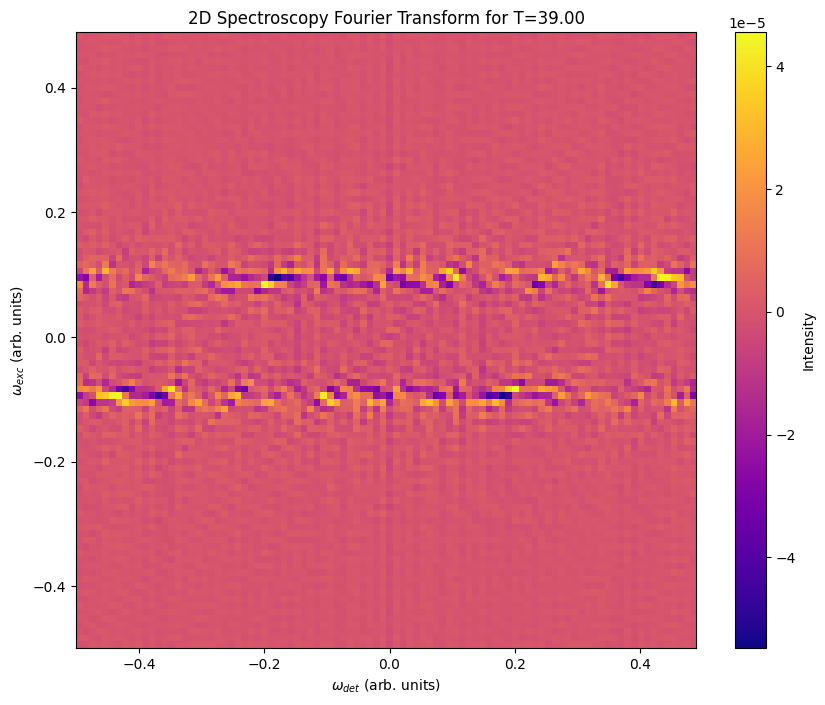

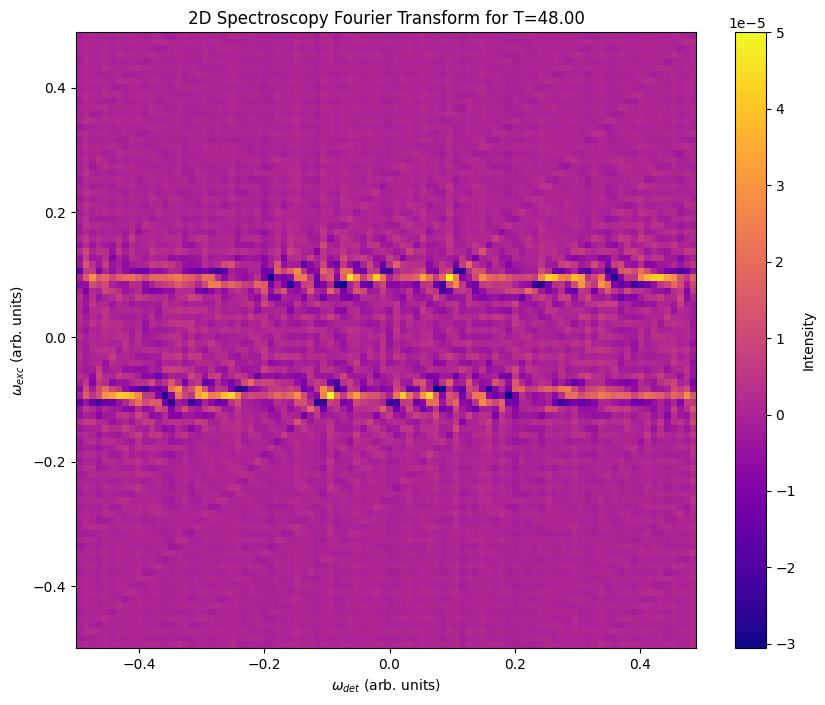

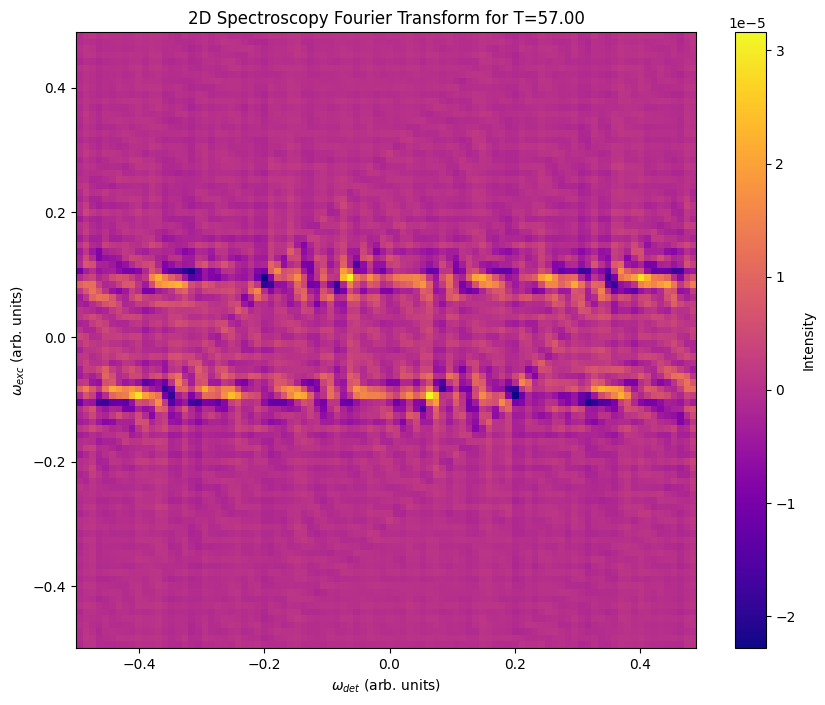

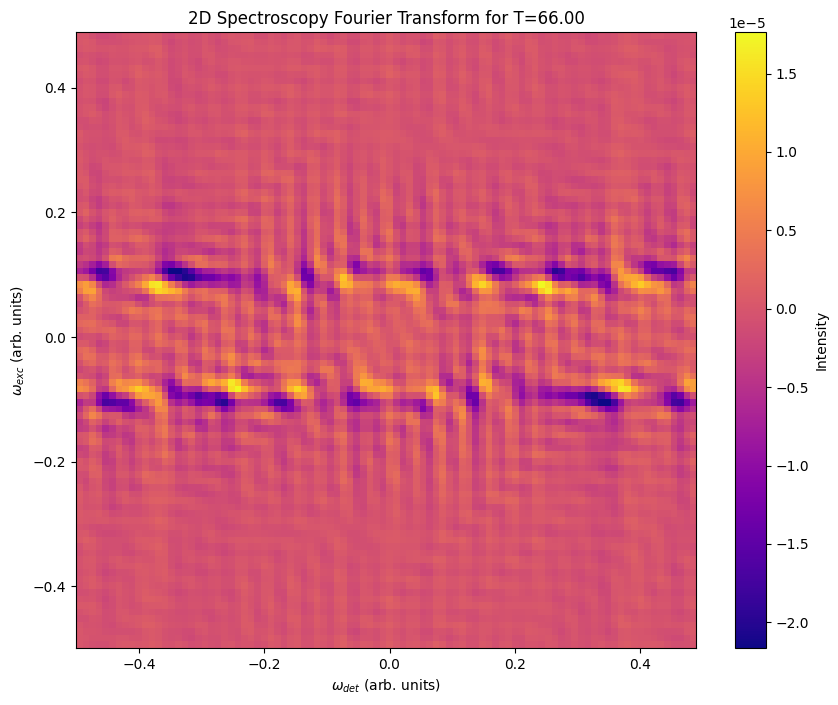

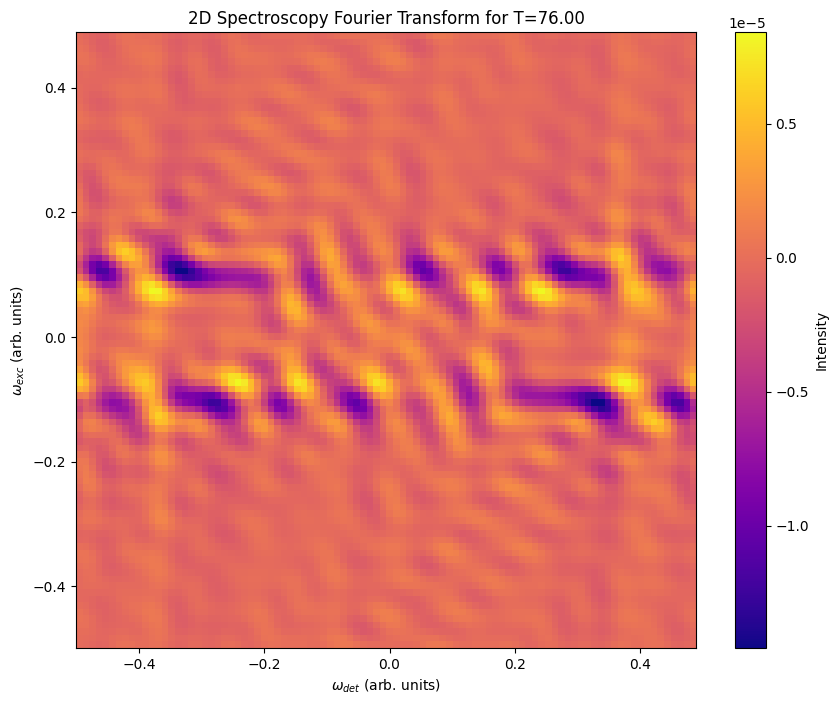

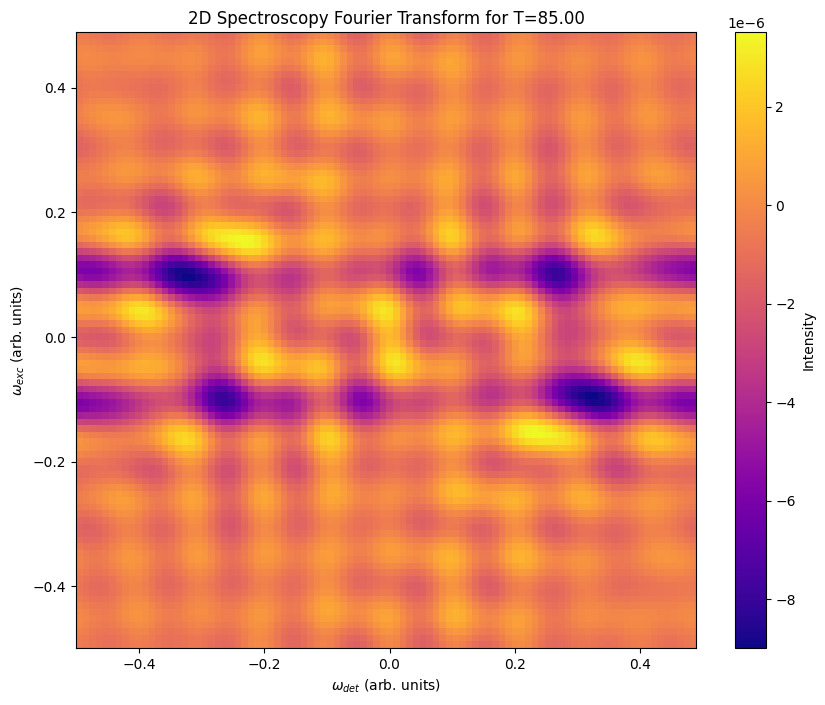

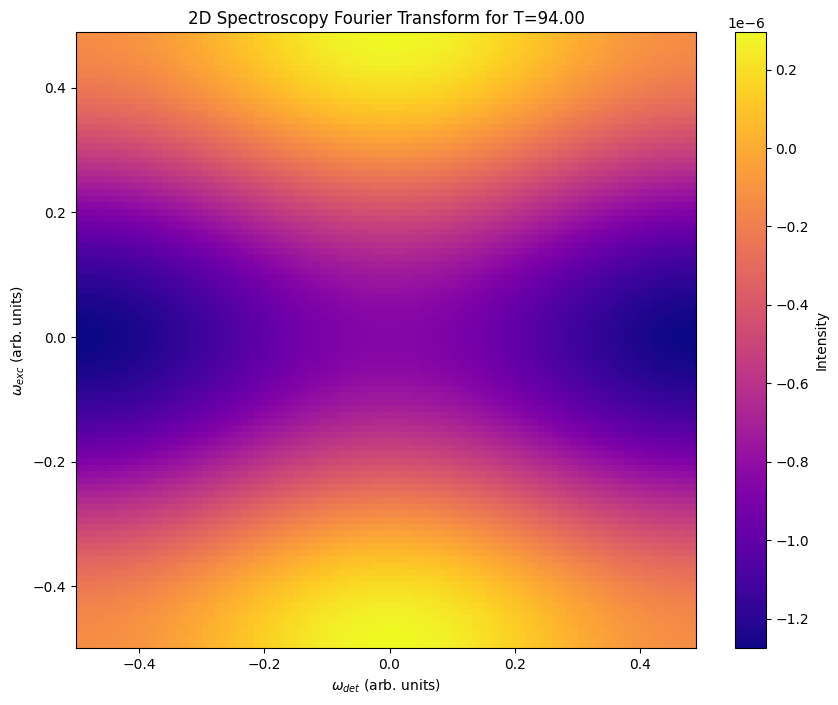

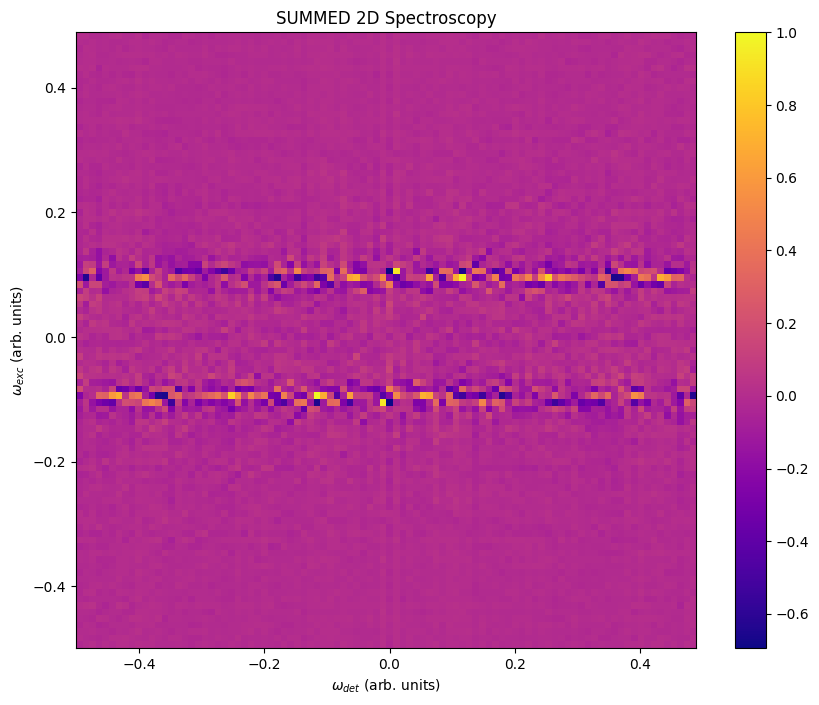

In [48]:
summed_A = 0
#
# PLOT THE GLOBAL DATA IN FREQUENCY SPACE AND THE SUM
#
global_t_freqs = np.fft.fftshift(np.fft.fftfreq(len(global_ts), d=(global_ts[1] - global_ts[0])))  # Frequency axis for detection time
global_tau_freqs = np.fft.fftshift(np.fft.fftfreq(len(global_taus), d=(global_taus[1] - global_taus[0])))  # Frequency axis for excitation time
#global_t_freqs = global_t_freqs[len(global_ts) // 2:]
#global_tau_freqs = global_tau_freqs[len(global_taus) // 2:]

for idx, (T, T_data) in enumerate(T_dictionary_full.items()):
    if idx not in valid_indices:  # Ensure only valid indices are selected
        continue
    data = T_data["data"]  # Aligned 2D data
    if len(ts) < 2 or len(taus) < 2:  # Ensure meaningful dimensions
        continue
    # Compute 2D Fourier Transform on the `data` array
    FT_data = np.fft.fft2(data)
    FT_data = np.fft.fftshift(FT_data)
#    FT_data = FT_data[len(global_ts) // 2:, len(global_taus) // 2:]

    # Extract the subset of FT_data corresponding to positive frequencies
    epsilon = 1e-10  # Small value to avoid division by zero
    A = np.real(FT_data)#-global_t_freqs[:, np.newaxis] * np.imag(
#        FT_data / (freq_taus[:, np.newaxis] + epsilon))
    max = np.max(np.abs(A))

    # Plot the result using imshow
    plt.figure(figsize=(10, 8))
    extent = [global_tau_freqs.min(), global_tau_freqs.max(), global_t_freqs.min(), global_t_freqs.max()]
    plt.imshow(A, extent=extent, origin='lower', aspect='auto', cmap='plasma')
    plt.colorbar(label="Intensity")
    plt.title(f"2D Spectroscopy Fourier Transform for T={T:.2f}")
    plt.ylabel("$\omega_{exc}$ (arb. units)")  # Excitation frequency
    plt.xlabel("$\omega_{det}$ (arb. units)")  # Detection frequency
    plt.show()    # Plot the result using imshow

    summed_A += A

max = np.max(np.abs(summed_A))
summed_A /= max
plt.figure(figsize=(10, 8))
extent = [np.min(global_tau_freqs), np.max(global_tau_freqs), np.min(global_t_freqs), np.max(global_t_freqs)]
plt.imshow(summed_A, extent=extent, origin='lower', aspect='auto', cmap='plasma')
plt.colorbar()
plt.title("SUMMED 2D Spectroscopy")
plt.ylabel("$\omega_{exc}$ (arb. units)")
plt.xlabel("$\omega_{det}$ (arb. units)")
file_name_combined = f"Cavity_Summed_in_freq_space__plot_lam{fixed_lam:.1f}_alpha={alpha:.2f}_g_0{gamma_0:.2f}_g_phi{gamma_phi:.2f}_{n_rings}x{n_chains}_dist={distance:.2f}.svg"
save_path_combined = "/home/leopold/PycharmProjects/Master_thesis/Figures_From_Python/" + file_name_combined
plt.savefig(save_path_combined)
plt.show()